<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/rlrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas==0.24.2
!pip install --upgrade protobuf==3.6.1
!pip install --upgrade folium==0.8.3
!pip install --upgrade imgaug==0.2.9
!pip install carball --quiet
!pip install shap --quiet
!pip install pandas-datareader --upgrade --quiet

     |████████████████████████████████| 10.1MB 5.0MB/s 
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.24.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.24.2 which is incompatible.
ERROR: mizani 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.24.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.24.2 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.24.2 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 1.1MB 5.4MB/s 
ERROR: tensorflow 2.4.0 has requirement protobuf>=3.9.2, but you'll have protobuf 3.6.1 which is incompatible.
ERROR: tensorflow-metadata 0.26.0 has requirement protobuf<4,>=3.7, but you'll have protobuf 3.6.1 which is incompatible.
ERROR: tensorflow-hub 0.11.0 has requirement protobuf>=3.8.0, but you'll have protobuf 3.6.1 which is incompatible.
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


Requirement already up-to-date: folium==0.8.3 in /usr/local/lib/python3.6/dist-packages (0.8.3)
Requirement already up-to-date: imgaug==0.2.9 in /usr/local/lib/python3.6/dist-packages (0.2.9)
     |████████████████████████████████| 163kB 6.9MB/s 
     |████████████████████████████████| 10.0MB 6.7MB/s 
     |████████████████████████████████| 20.2MB 1.2MB/s 
     |████████████████████████████████| 481kB 56.4MB/s 
ERROR: tensorflow 2.4.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement protobuf>=3.9.2, but you'll have protobuf 3.6.1 which is incompatible.
ERROR: tensorflow-hub 0.11.0 has requirement protobuf>=3.8.0, but you'll have protobuf 3.6.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.0.3 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 1.0.3 which is incompatible.
ERROR: data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import warnings
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, confusion_matrix
import itertools
import random
import shap
import carball
import os
import gzip
from carball.json_parser.game import Game
from carball.analysis.analysis_manager import AnalysisManager
sns.set_context('talk')

In [ ]:
def load_rl_replay(rl_replay_file):
  _json = carball.decompile_replay(rl_replay_file,
                                  output_path='rl_game.json',
                                  overwrite=True)

  game = Game()
  game.initialize(loaded_json=_json)
  analysis_manager = AnalysisManager(game)
  analysis_manager.create_analysis()

  # write proto out to a file
  # read api/*.proto for info on the object properties
  with open(os.path.join('output.pts'), 'wb') as fo:
      analysis_manager.write_proto_out_to_file(fo)

  # write pandas dataframe out as a gzipped numpy array
  with gzip.open(os.path.join('output.gzip'), 'wb') as fo:
      analysis_manager.write_pandas_out_to_file(fo)

  # return the proto object in python
  proto_object = analysis_manager.get_protobuf_data()

  # return the pandas data frame in python
  dataframe = analysis_manager.get_data_frame()
  return dataframe, game, proto_object

def get_df_players(game):
  df_players = pd.DataFrame()
  for x in game.players:
    df_players = (df_players
                  .append(pd.DataFrame([[int(x.online_id),x.name,x.team.name,x.is_orange]],
                                      columns=['id','name','team','is_orange']),
                          ignore_index=True))
  return df_players

def get_game_info(game):
  warnings.filterwarnings("ignore")
  df_players = get_df_players(game)
  game_info = pd.DataFrame([[format(game.datetime,"%Y%m%d%H%M%S"),game.game_info.match_guid,int(game.name[4]),game.id]],columns=['match_date','match_id','game_number','game_id'])
  game_info = pd.concat([game_info,df_players],axis=1)
  game_info = game_info.fillna(method='ffill')
  return game_info

def get_df_game(dataframe,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date', 'match_id', 'game_number', 'game_id']
  _game_info = game_info.loc[[1],game_info_cols].drop_duplicates()

  df_game = dataframe['game']
  df_game['goal_number'] = df_game['goal_number'].fillna(-np.inf)
  df_game['seconds'] = df_game['seconds_remaining'].sub(300).abs()
  df_game = pd.concat([_game_info,df_game],axis=1)
  df_game = df_game.reset_index().rename(columns={'index':'frames'})
  df_game.loc[:,game_info_cols] = df_game.loc[:,game_info_cols].fillna(method='ffill')
  return df_game

def get_df_hits(proto_object,game):
  name_map = {player.name: int(player.online_id) for player in game.players}
  _id2name = pd.DataFrame.from_dict([name_map]).T.reset_index().rename(columns={'index':'player_name',0:'player_id'})
  hits = proto_object.game_stats.hits
  df_hits = pd.DataFrame()
  for hit in hits:
    _df = pd.DataFrame([[proto_object.game_metadata.match_guid,proto_object.game_metadata.id,hit.goal,hit.frame_number,int(hit.player_id.id),hit.collision_distance,hit.ball_data.pos_x,hit.ball_data.pos_y,hit.ball_data.pos_z,hit.distance,hit.distance_to_goal,hit.next_hit_frame_number,hit.goal_number,hit.is_kickoff]],columns=['match_id','game_id','goal','frame_number','player_id','collision_distance','pos_x','pos_y','pos_z','distance','distance_to_goal','next_hit_frame_number','goal_number','is_kickoff'])
    df_hits = df_hits.append(_df,ignore_index=True)
  df_hits = df_hits.merge(_id2name)
  return df_hits

def flatten_dataframe(dataframe,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date','match_id','game_number','game_id','id','name','team','is_orange']
  to_melt = [x for x in dataframe.columns.levels[0].values if x not in ['ball', 'game']]

  flat_df = pd.DataFrame()
  for player_name in to_melt:
    _df = dataframe[player_name]
    _df = _df.reset_index().rename(columns={'index':'frames'})
    column_list = _df.columns.values
    column_list = game_info_cols+column_list.tolist()
    _df = pd.concat([game_info.loc[game_info['name']==player_name],_df],axis=1)
    _df.loc[:,game_info_cols] = _df.loc[:,game_info_cols].fillna(method='bfill').fillna(method='ffill')
    flat_df = flat_df.append(_df,ignore_index=True)
  flat_df = flat_df.loc[:,column_list]
  flat_df = generate_zones(flat_df)
  return flat_df



def generate_zones(df):
  df.loc[df['pos_x']<-1333,'x_zone'] = -1
  df.loc[df['pos_x'].between(-1333,1333),'x_zone'] = 0
  df.loc[df['pos_x']>1333,'x_zone'] = 1

  df.loc[df['pos_y']<-2000,'y_zone'] = -1
  df.loc[df['pos_y'].between(-2000,2000),'y_zone'] = 0
  df.loc[df['pos_y']>2000,'y_zone'] = 1

  df.loc[df['pos_z']<500,'z_zone'] = 0
  df.loc[df['pos_z'].between(500,1500),'z_zone'] = 1
  df.loc[df['pos_z']>1500,'z_zone'] = 2
  return df

def get_df_ball(dataframe,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date', 'match_id', 'game_number', 'game_id']
  _game_info = game_info.loc[[1],game_info_cols].drop_duplicates()
  df_ball = dataframe['ball']
  df_ball = generate_zones(df_ball)
  df_ball = pd.concat([_game_info,df_ball],axis=1)
  df_ball = df_ball.reset_index().rename(columns={'index':'frames'})
  df_ball.loc[:,game_info_cols] = df_ball.loc[:,game_info_cols].fillna(method='ffill')
  return df_ball



def get_df_goals(game,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date', 'match_id', 'game_number', 'game_id']
  _game_info = game_info.loc[[1],game_info_cols].drop_duplicates()
  df_goals = pd.DataFrame()
  for idx_goal in range(len(game.goals)):
    goal = game.goals[idx_goal]
    df_goal = pd.DataFrame([[int(goal.player.online_id),goal.player.name,bool(goal.player_team),goal.frame_number]], columns=['id','name','is_orange','goal_frame_number'])
    df_goals = df_goals.append(df_goal,ignore_index=True)
    df_goals = df_goals.sort_values('goal_frame_number').reset_index(drop=True)
  df_goals = pd.concat([_game_info,df_goals],axis=1)
  df_goals.loc[:,game_info_cols] = df_goals.loc[:,game_info_cols].fillna(method='ffill').fillna(method='bfill')
  return df_goals

def plot_gridlines(view='xy'):
  if view=='xy':
    plt.axvline(-4000,c='k')
    plt.axvline(4000,c='k')
    plt.axvline(1333,c='r',ls=':')
    plt.axvline(-1333,c='r',ls=':')

    plt.axhline(-6000,c='k')
    plt.axhline(6000,c='k')
    plt.axhline(-2000,c='r',ls=':')
    plt.axhline(2000,c='r',ls=':')

  elif view=='xz':
    plt.axvline(-4000,c='k')
    plt.axvline(4000,c='k')
    plt.axvline(1333,c='r',ls=':')
    plt.axvline(-1333,c='r',ls=':')

    plt.axhline(0,c='k')
    plt.axhline(2000,c='k')
    plt.axhline(500,c='r',ls=':')
    plt.axhline(1500,c='r',ls=':')

  elif view=='yz':
    plt.axvline(-6000,c='k')
    plt.axvline(6000,c='k')
    plt.axvline(-2000,c='r',ls=':')
    plt.axvline(2000,c='r',ls=':')

    plt.axhline(0,c='k')
    plt.axhline(2000,c='k')
    plt.axhline(500,c='r',ls=':')
    plt.axhline(1500,c='r',ls=':')

  sns.despine(left=True,bottom=True)

def make_positional_heatmap(player_name,sample=15000,zone_type='xy'):
  warnings.filterwarnings("ignore")
  df_player = flat_df.loc[flat_df['name']==player_name].sample(sample)

  if zone_type == 'xy':
    axis_1 = 'x'
    axis_2 = 'y'
    index = {-1:'atk',0:'mid',1:'def'}
    columns = {-1:'left',0:'center',1:'right'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'].mul(-1)

  elif zone_type == 'xz':
    axis_1 = 'x'
    axis_2 = 'z'
    columns = {-1:'left',0:'center',1:'right'}
    index = {0:'floor',-1:'air',-2:'ceiling'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)

  elif zone_type == 'yz':
    axis_1 = 'y'
    axis_2 = 'z'
    columns = {-1:'atk',0:'mid',1:'def'}
    index = {0:'floor',-1:'air',-2:'ceiling'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)

  df_position = df_player.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frames']].groupby([f'{axis_1}_zone',f'{axis_2}_zone'],as_index=False).sum()
  df_position['frame_pct'] = df_position['frames'].div(df_position['frames'].sum())
  _df = pd.pivot_table(df_position.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frame_pct']],
                values=['frame_pct'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
  _df = _df.rename(index=index,columns=columns)
  _df = _df['frame_pct']

  avg_heatmap = _get_avg_heatmap(flat_df,zone_type=zone_type)
  _df = (_df.sub(avg_heatmap)).div(avg_heatmap)

  f = sns.heatmap(_df,vmin=-0.5,vmax=0.5,cmap='coolwarm',square=True)
  b, t = f.get_ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  f.set_ylim(b, t) # update the ylim(bottom, top) values
  plt.title(f"{player_name}")
  plt.show()

def calc_magnitude(df):
  magnitude = np.sqrt(df['vel_x']**2+df['vel_y']**2+df['vel_z']**2)
  return magnitude

def touches2modeldata(tid,touches):
  stat_cols = ['goals_per_game', 'hits_per_game', 'goals_per_hit',
              'x_zone', 'y_zone', 'z_zone', 'x_zone_pct',
              'y_zone_pct', 'z_zone_pct']

  _team = touches.loc[touches['team']==tid]
  id_shuffle = _team['id'].unique().tolist()
  random.shuffle(id_shuffle)
  for idx,pid in enumerate(id_shuffle):
    rename_stat_cols = {k:f"{k}_{idx}" for k in stat_cols}
    _player = _team.loc[_team['id']==pid,stat_cols].rename(columns=rename_stat_cols)
    if idx == 0:
      team = _player
    else:
      team = pd.concat([team.reset_index(drop=True),_player.reset_index(drop=True)],axis=1)

  return team

def matchup_win_prob(model_data,touches,team1,team2='BULL SEND'):
  model_feats = ['goals_per_game_0_0', 'goals_per_game_1_0',
        'goals_per_game_2_0', 'goals_per_hit_0_0', 'goals_per_hit_1_0',
        'goals_per_hit_2_0', 'hits_per_game_0_0', 'hits_per_game_1_0',
        'hits_per_game_2_0', 'x_zone_0_0', 'x_zone_1_0',
        'x_zone_2_0', 'x_zone_pct_0_0', 'x_zone_pct_1_0', 'x_zone_pct_2_0',
        'y_zone_0_0', 'y_zone_1_0', 'y_zone_2_0', 'y_zone_pct_0_0',
        'y_zone_pct_1_0', 'y_zone_pct_2_0', 'z_zone_0_0', 'z_zone_1_0',
        'z_zone_2_0', 'z_zone_pct_0_0', 'z_zone_pct_1_0', 'z_zone_pct_2_0',
        'goals_per_game_0_1', 'goals_per_game_1_1', 'goals_per_game_2_1',
        'goals_per_hit_0_1', 'goals_per_hit_1_1', 'goals_per_hit_2_1',
        'hits_per_game_0_1', 'hits_per_game_1_1', 'hits_per_game_2_1',
        'x_zone_0_1', 'x_zone_1_1', 'x_zone_2_1',
        'x_zone_pct_0_1', 'x_zone_pct_1_1', 'x_zone_pct_2_1', 'y_zone_0_1',
        'y_zone_1_1', 'y_zone_2_1', 'y_zone_pct_0_1', 'y_zone_pct_1_1',
        'y_zone_pct_2_1', 'z_zone_0_1', 'z_zone_1_1', 'z_zone_2_1',
        'z_zone_pct_0_1', 'z_zone_pct_1_1', 'z_zone_pct_2_1']

  target = 'win'

  win_prob_data = get_win_prob_data(team1, team2,touches)
  win_prob = get_win_probability(team1, team2,model_data,win_prob_data)
  return win_prob[0][1]

def get_win_probability(opp_id,bullsend_id,model_data,win_prob_data):
  train_data = model_data.loc[(~model_data['team_0'].isin([opp_id,bullsend_id]))&(~model_data['team_1'].isin([opp_id,bullsend_id]))]
  matchup_model = LogisticRegression()
  matchup_model.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
  win_prob = matchup_model.predict_proba(win_prob_data.loc[:,model_feats])
  return win_prob

def get_increments(model_data):
  dist_cols = [x for x in model_data.columns.values if x[-3:]=='0_0']
  increments = {}
  for col in dist_cols:
    pct_diff = [model_data[col].drop_duplicates().quantile(x)-model_data[col].drop_duplicates().quantile(y) for y,x in zip(np.arange(0.01,1.00,0.01),np.arange(0.02,1.01,0.01))]
    increments[col[:-4]] = np.median(pct_diff)
  return increments

def get_win_prob_data(team1, team2,touches):
  _opp = touches2modeldata(team1,touches)
  _bull = touches2modeldata(team2,touches)
  win_prob_data = _opp.merge(_bull,left_index=True, right_index=True,suffixes=('_0','_1')).dropna()
  return win_prob_data

def data_tuning(win_prob_data, increments, col, improve=True):
  df = win_prob_data.copy()
  if improve:
    team_str = '1'
  else:
    team_str = '0'
  cols_to_tune = [y for y in [x for x in win_prob_data.columns.values if x[:-4] in col] if y[-1] == team_str]
  rand_col = random.choice(cols_to_tune)
  df.loc[:,rand_col] = win_prob_data.loc[:,rand_col].add(increments[col])
  return df

# pipeline design
take in data in batch   
flatten data  
tag each match with UID  
season column  
unique team ID  
unique player ID  


code IDs as strings (then recode them as smaler int)


In [ ]:
root_dir = '/content/drive/My Drive/rocket_league'
season_fns = os.listdir(root_dir)
league_fn = f'{root_dir}/data/RLCS Season 8/RLCS NA League Play'

flat_df = pd.DataFrame()
df_goals = pd.DataFrame()
df_game = pd.DataFrame()
df_ball = pd.DataFrame()
df_hits = pd.DataFrame()

week_fns = os.listdir(league_fn)
for week_fn in week_fns:
  match_fns = os.listdir(f"{league_fn}/{week_fn}")
  for match_fn in match_fns:
    replay_files = os.listdir(f"{league_fn}/{week_fn}/{match_fn}")
    for replay_file in replay_files:
      fn = f"{league_fn}/{week_fn}/{match_fn}/{replay_file}"
      dataframe, game, proto_object = load_rl_replay(fn)
      game_info = get_game_info(game)
      _df_hits = get_df_hits(proto_object,game)
      _flat_df = flatten_dataframe(dataframe,game_info)
      _df_goals = get_df_goals(game,game_info)
      _df_game = get_df_game(dataframe,game_info)
      _df_ball = get_df_ball(dataframe,game_info)
      flat_df = flat_df.append(_flat_df,ignore_index=True)
      df_goals = df_goals.append(_df_goals,ignore_index=True)
      df_game = df_game.append(_df_game,ignore_index=True)
      df_ball = df_ball.append(_df_ball,ignore_index=True)
      df_hits = df_hits.append(_df_hits,ignore_index=True)



Need to redownload rattletrap
Cloud parser is highest binary
Player RLCS Admin as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Admin as player has no team.
Player RLCS Observer 2 as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer 2 as player has no team.
Player RLCS Observer 3 as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer 3 as player has no team.
Player RLCS Observer 1 as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer 1 as player has no team.
Dropping these columns[('game', 'is_overtime')]
STRAIGHT TIME 2.051375
SUM TIME0.0
STRAIGHT TIME 2.0508800000000065
SUM TIME0.0
STRAIGHT TIME 1.9429400000000214
SUM TIME0.0
The player never hit the ball during the "carry"
The player never hit the ball during the "carry"
Player RLCS Admin as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Admin as player has no team

In [ ]:
flat_df.to_csv('/content/drive/My Drive/rlrs/data/flat_df.csv',index=False)
df_goals.to_csv('/content/drive/My Drive/rlrs/data/df_goals.csv',index=False)
df_game.to_csv('/content/drive/My Drive/rlrs/data/df_game.csv',index=False)
df_ball.to_csv('/content/drive/My Drive/rlrs/data/df_ball.csv',index=False)
df_hits.to_csv('/content/drive/My Drive/rlrs/data/df_hits.csv',index=False)

# XYZ zone codes:  
**X zones:**  
-1 = "left" or "west" or <-1333 x values  
0 = "center" or between -1333 and +1333  
1 = "right" or "east" or >1333  

**Y zones:**  
-1 = "bottom" or "south" or "blue side" or <-2000 y values  
0 = "center" or between -2000 and +2000  
1 = "top" or "north" or "red side" or >2000  

**Z zones:**  
0 = "ground" or "floor" or <+500 z values  
1 = "aerial" or 500 and 1500  
2 = "ceiling" or >1500  


In [ ]:
df_ball.shape

(843612, 21)

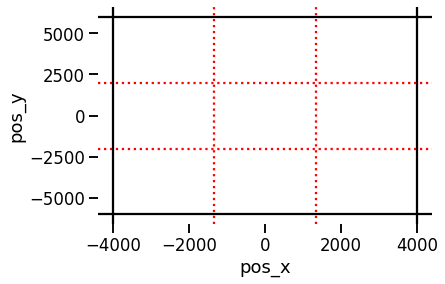

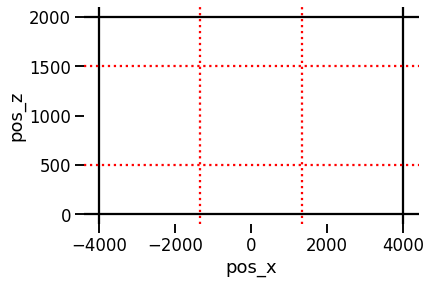

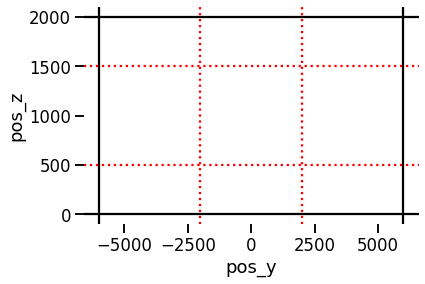

In [ ]:
_df = df_ball.sample(5000)
sns.kdeplot(_df['pos_x'],_df['pos_y'])
plot_gridlines(view='xy')
plt.show()

sns.kdeplot(_df['pos_x'],_df['pos_z'])
plot_gridlines(view='xz')
plt.show()

sns.kdeplot(_df['pos_y'],_df['pos_z'])
plot_gridlines(view='yz')
plt.show()

In [ ]:
player_name = 'Taroco'
df_player = flat_df.loc[flat_df['name']==player_name]
df_player.loc[df_player['is_orange']==0,'y_zone'] = df_player.loc[df_player['is_orange']==0,'y_zone'].mul(-1)
df_position = df_player.loc[:,['x_zone','y_zone','frames']].groupby(['x_zone','y_zone'],as_index=False).sum()

In [ ]:
def _get_avg_heatmap(flat_df,zone_type='xy'):
  df_player = flat_df.loc[:].sample(100000)

  if zone_type == 'xy':
    axis_1 = 'x'
    axis_2 = 'y'
    index = {-1:'atk',0:'mid',1:'def'}
    columns = {-1:'left',0:'center',1:'right'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'].mul(-1)

  elif zone_type == 'xz':
    axis_1 = 'x'
    axis_2 = 'z'
    columns = {-1:'left',0:'center',1:'right'}
    index = {0:'floor',-1:'air',-2:'ceiling'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)

  elif zone_type == 'yz':
    axis_1 = 'y'
    axis_2 = 'z'
    columns = {-1:'atk',0:'mid',1:'def'}
    index = {0:'floor',-1:'air',-2:'ceiling'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)

  df_position = df_player.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frames']].groupby([f'{axis_1}_zone',f'{axis_2}_zone'],as_index=False).sum()
  df_position['frame_pct'] = df_position['frames'].div(df_position['frames'].sum())
  _df = pd.pivot_table(df_position.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frame_pct']],
                values=['frame_pct'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
  _df = _df.rename(index=index,columns=columns)
  _df = _df['frame_pct']
  return _df

In [ ]:
player_name = 'Taroco'
sample=15000
zone_type = 'xz'

df_player = flat_df.loc[flat_df['name']==player_name].sample(sample)

if zone_type == 'xy':
  axis_1 = 'x'
  axis_2 = 'y'
  index = {-1:'atk',0:'mid',1:'def'}
  columns = {-1:'left',0:'center',1:'right'}
  df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'].mul(-1)

elif zone_type == 'xz':
  axis_1 = 'x'
  axis_2 = 'z'
  columns = {-1:'left',0:'center',1:'right'}
  index = {0:'floor',-1:'air',-2:'ceiling'}
  df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)

elif zone_type == 'yz':
  axis_1 = 'y'
  axis_2 = 'z'
  columns = {-1:'atk',0:'mid',1:'def'}
  index = {0:'floor',-1:'air',-2:'ceiling'}
  df_player.loc[:,f'{axis_1}_zone'] = df_player.loc[:,f'{axis_1}_zone'].mul(-1)
  df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)

df_position = df_player.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frames']].groupby([f'{axis_1}_zone',f'{axis_2}_zone'],as_index=False).sum()
df_position['frame_pct'] = df_position['frames'].div(df_position['frames'].sum())
_df = pd.pivot_table(df_position.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frame_pct']],
              values=['frame_pct'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
_df = _df.rename(index=index,columns=columns)
_df = _df['frame_pct']

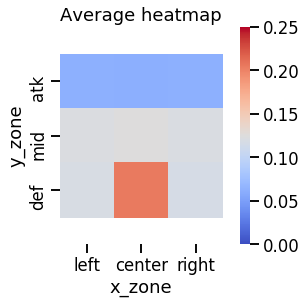

In [ ]:
_df = _get_avg_heatmap(flat_df)
f = sns.heatmap(_df,vmin=0,vmax=0.25,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values
plt.title(f"Average heatmap")
plt.show()

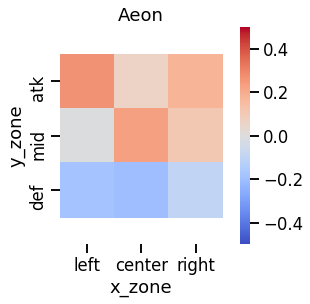

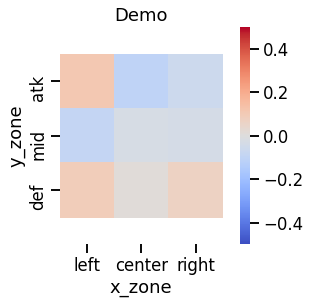

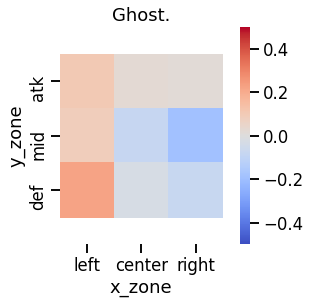

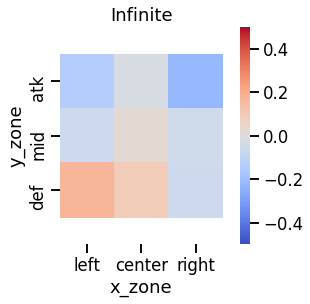

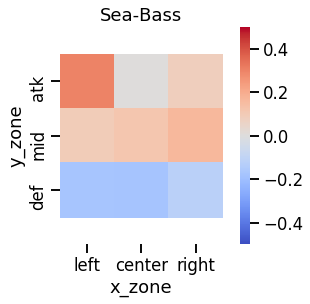

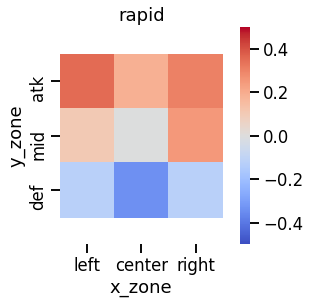

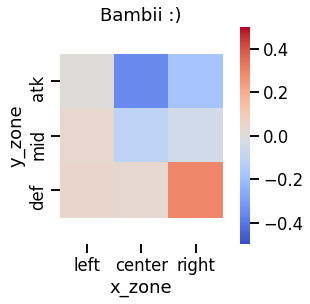

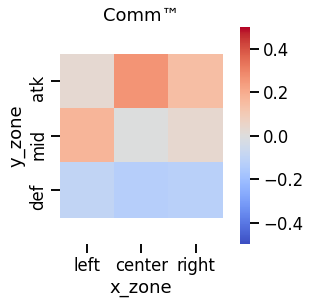

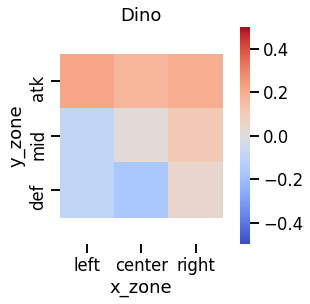

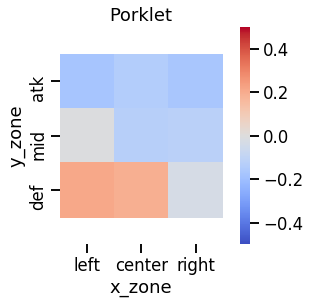

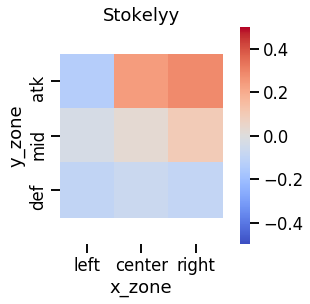

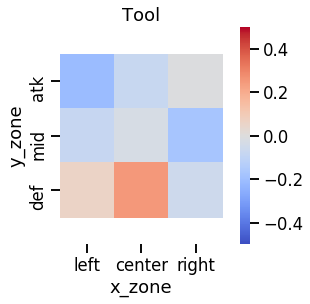

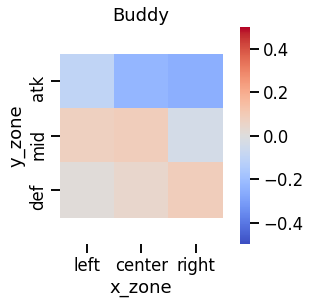

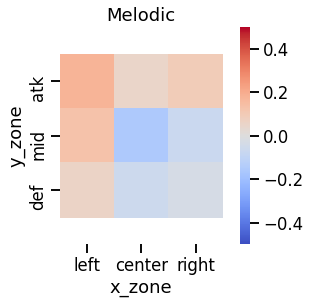

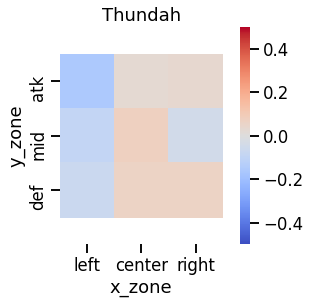

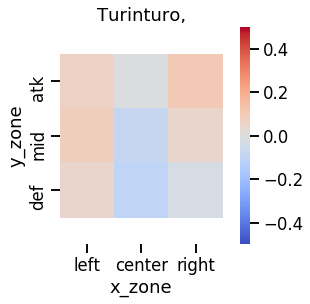

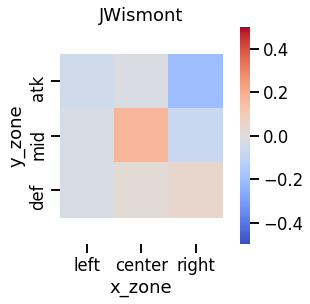

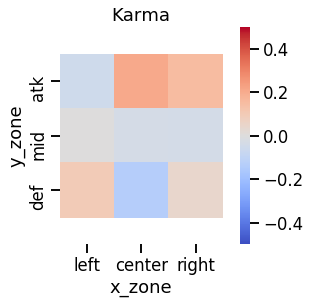

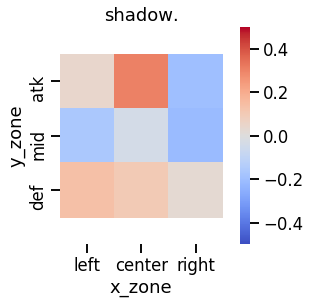

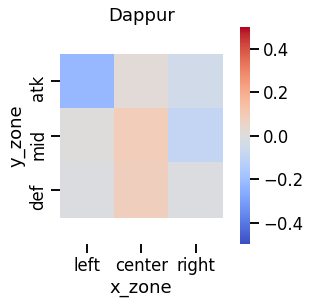

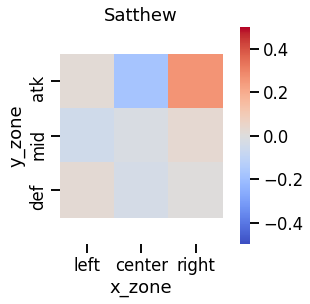

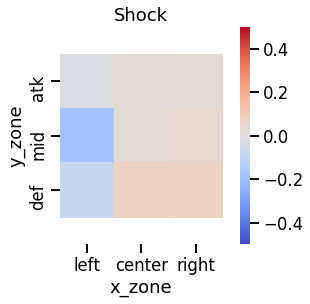

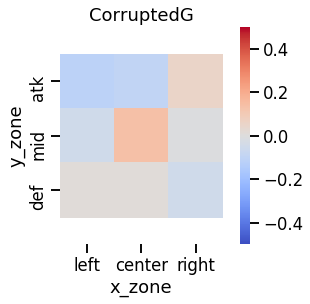

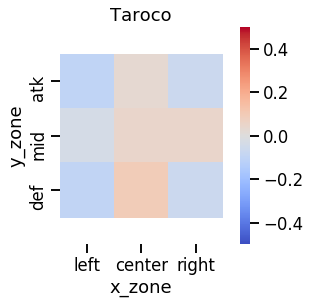

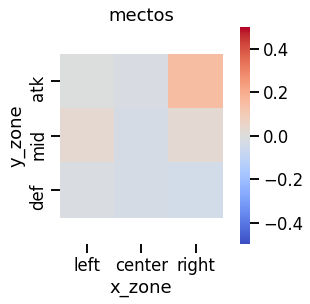

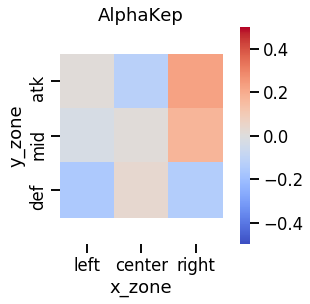

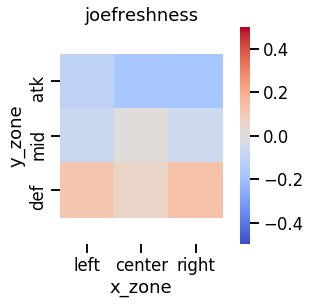

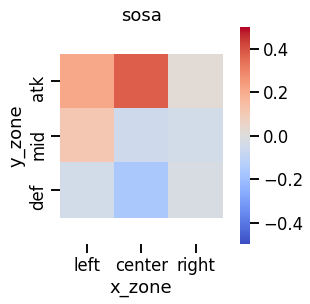

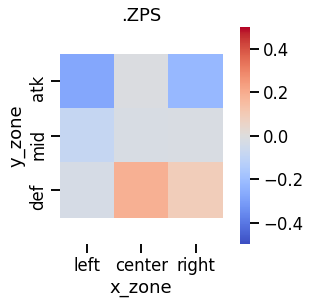

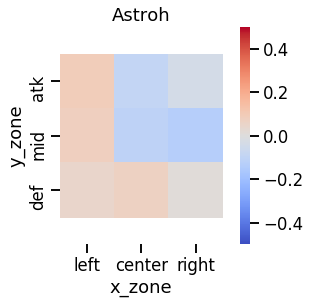

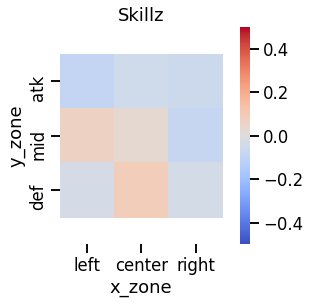

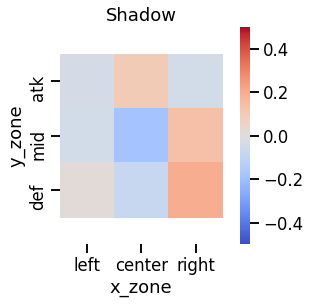

In [ ]:
for player_name in flat_df['name'].unique():
  make_positional_heatmap(player_name,zone_type='xy')

In [ ]:
df_game['match_id'].sample(1)

299990    F31D6F7211E9F20799EF0985A9D8C6B3
Name: match_id, dtype: object

In [ ]:
frames_per_sec = [(df_game
                   .loc[(df_game['match_id']==match)&
                        (df_game['seconds_remaining']==300)&
                        (df_game['frames']<=300),'frames']
                   .max()) for match in df_game['match_id'].unique()]

np.mean(frames_per_sec)

195.47058823529412

In [ ]:
df_goals['game_id'].sample(4)

128    BD2728B54D413568B856C99D57FD880C
50     ABC27EE244A1A26AD951B6AD97DF0F69
171    3130DCD94442784BE435DC90F75CED30
189    640C63F54C28179D82BCD9BBA42670D0
Name: game_id, dtype: object

In [ ]:
df_gps = df_goals.merge(df_game.loc[:,['frames','game_id','seconds', 'seconds_remaining']].rename(columns={'frames':'goal_frame_number'}))
_gps = pd.DataFrame()
for gid in df_goals['game_id'].unique():
  _df = df_gps.loc[df_gps['game_id']==gid].sort_values('seconds')
  _df['goal_time_diff'] = _df['seconds'].sub(_df['seconds'].shift().fillna(0))
  _gps = _gps.append(_df,ignore_index=True)
df_gps = _gps

df_goal_rt = pd.DataFrame()
for name in df_gps['name'].unique():
  df_goal_rt = (df_goal_rt
                .append(pd.DataFrame([[name,
                                       df_gps
                                       .loc[(df_gps['name']==name)&
                                            (df_gps['game_id']==df_gps['game_id'].shift())&
                                            (df_gps['is_orange']!=df_gps['is_orange'].shift().fillna(df_gps['is_orange'])),
                                            'goal_time_diff']
                                       .mean()]],
                                     columns=['name','avg_goal_rt'])))

_spg = pd.DataFrame()
for pid in df_goals['name'].unique():
  _df = df_game.loc[df_game['game_id'].isin(flat_df.loc[flat_df['name']==pid,'game_id'].unique())].sort_values('seconds',ascending=False).drop_duplicates(subset=['game_id'])
  _spg = _spg.append(pd.DataFrame([[pid,_df['seconds'].sum()/df_goals.loc[df_goals['name']==pid].shape[0]]],columns=['name','spg']),ignore_index=False)

df_gps_opp = df_gps.loc[(df_gps['is_orange']!=df_gps['is_orange'].shift().fillna(df_gps['is_orange']))&(df_gps['game_id']==df_gps['game_id'].shift())]

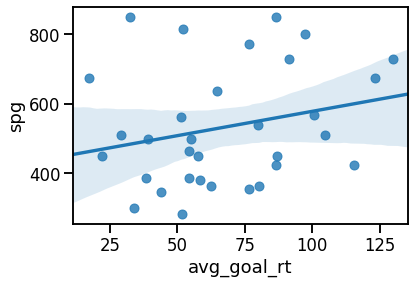

In [ ]:
sns.regplot('avg_goal_rt','spg',data=df_goal_rt.merge(_spg))

In [ ]:
_a = df_gps.loc[:,['name','id']].groupby('name',as_index=False).count().rename(columns={'id':'total_goals'})
_b = df_gps_opp.loc[:,['name','id']].groupby('name',as_index=False).count().rename(columns={'id':'tft_goals'})
_c = df_gps_opp.loc[:,['name','id','goal_time_diff']].groupby('name',as_index=False).mean()

df_plt = df_goal_rt.merge(_a).merge(_spg).merge(_b).merge(_c)
df_plt['goal_reaction_value'] = df_plt['tft_goals'].div(df_plt['goal_time_diff'])
df_plt['gps'] = 1/df_plt['spg']

for col in ['gps','goal_reaction_value']:
  df_plt[f"{col}_pc"] = (df_plt[col].sub(df_plt[col].mean())).div(df_plt[col].mean())

In [ ]:
df_plt['goal_scoring_player_value'] = df_plt['gps_pc'].mul(0.35) + df_plt['goal_reaction_value_pc'].mul(0.65)
df_plt.loc[:,['name','total_goals','tft_goals','spg','goal_reaction_value','goal_scoring_player_value']].sort_values('goal_scoring_player_value',ascending=False).reset_index(drop=True).shift().dropna()

,name,total_goals,tft_goals,spg,goal_reaction_value,goal_scoring_player_value
1,joefreshness,10.0,2.0,509.900000,0.266667,1.492851
2,Comm™,10.0,4.0,449.900000,0.238806,1.311428
3,Astroh,8.0,4.0,675.000000,0.197531,0.851430
4,Thundah,15.0,6.0,380.000000,0.160714,0.747979
5,"Turinturo,",16.0,5.0,356.250000,0.135870,0.576404
6,shadow.,8.0,4.0,300.000000,0.117647,0.517928
7,Tool,8.0,4.0,637.375000,0.137931,0.383354
8,Melodic,7.0,4.0,385.571429,0.104575,0.286685
9,Shock,13.0,4.0,346.153846,0.090909,0.225994
10,Sea-Bass,19.0,5.0,284.210526,0.076220,0.213646


# VARIABLE NAMES
* dick
* balls


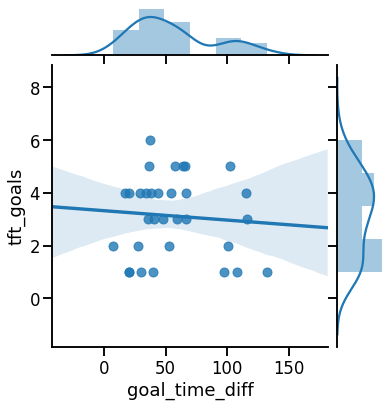

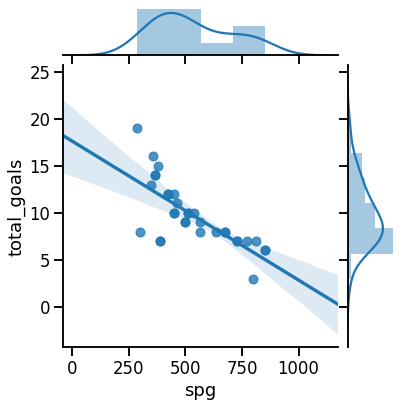

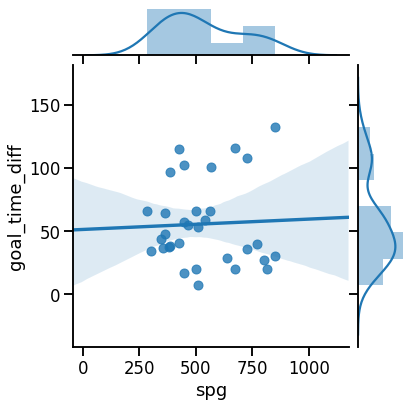

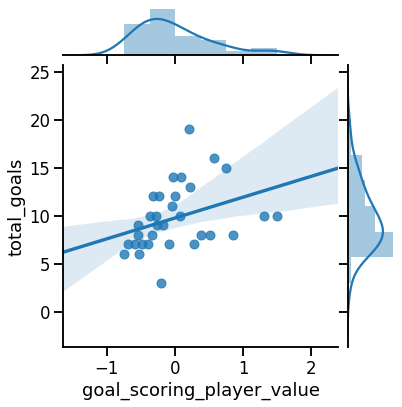

In [ ]:
sns.jointplot('goal_time_diff','tft_goals',data=df_plt,kind='reg')
plt.show()

sns.jointplot('spg','total_goals',data=df_plt,kind='reg')
plt.show()

sns.jointplot('spg','goal_time_diff',data=df_plt,kind='reg')
plt.show()

sns.jointplot('goal_scoring_player_value','total_goals',data=df_plt,kind='reg')
plt.show()

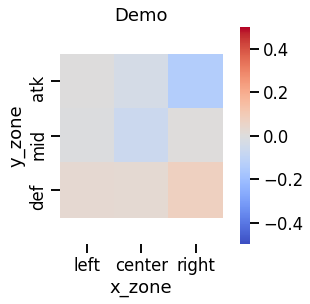

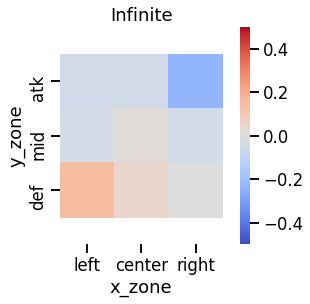

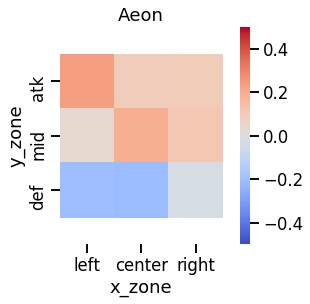

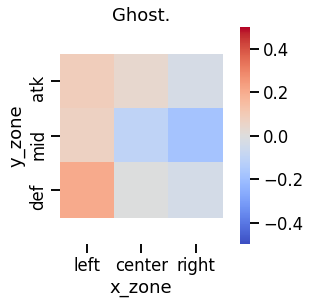

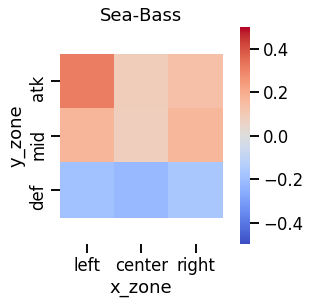

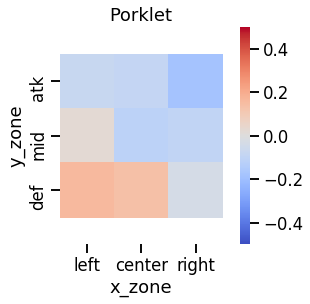

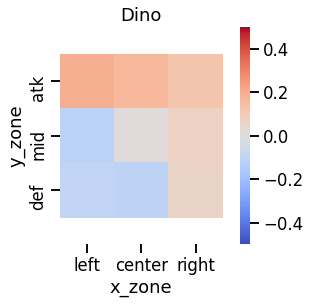

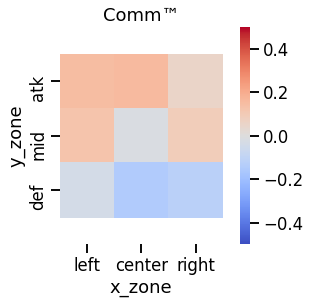

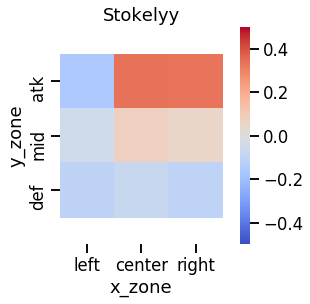

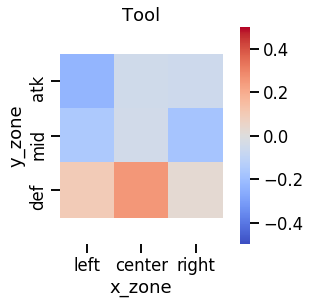

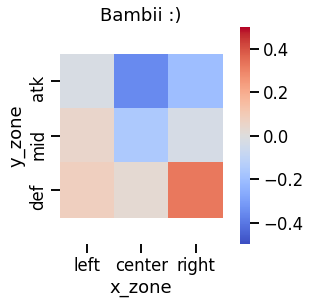

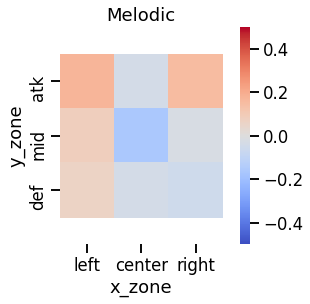

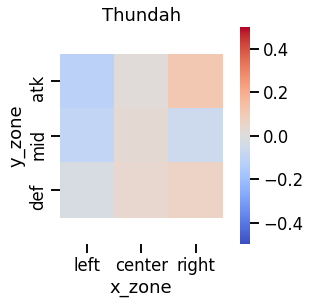

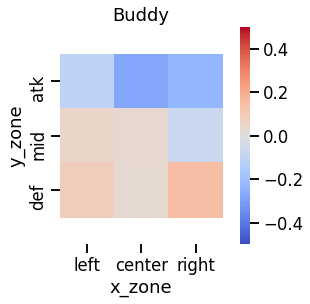

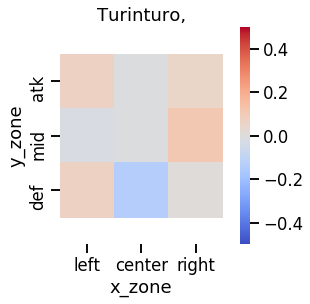

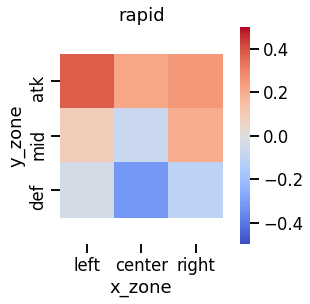

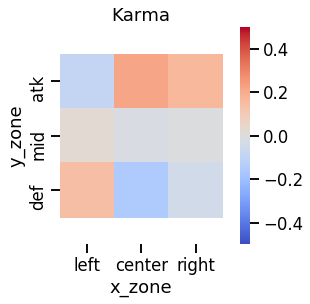

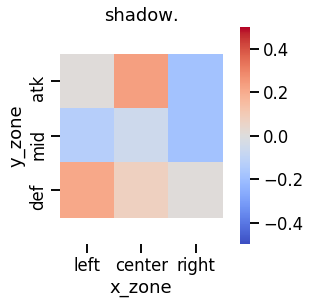

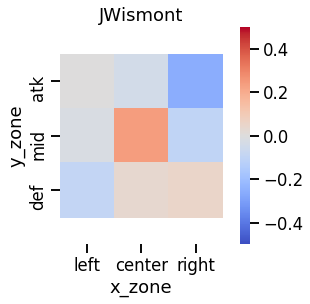

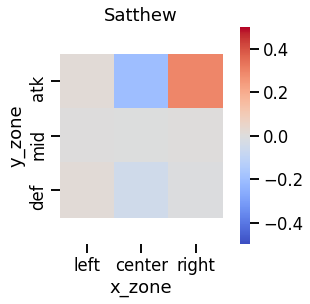

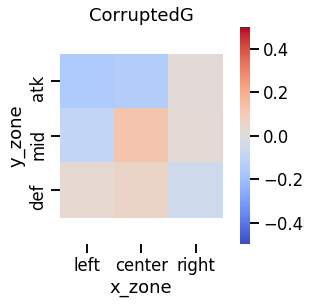

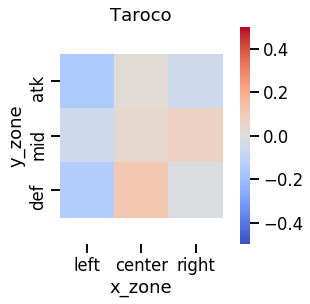

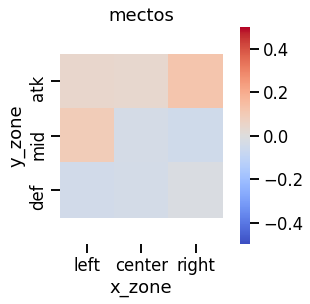

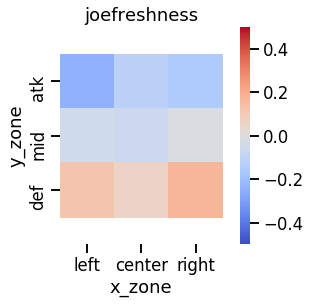

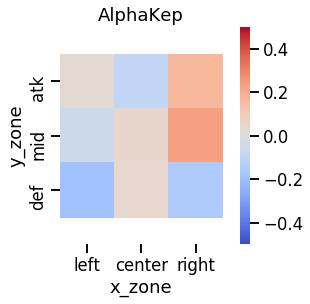

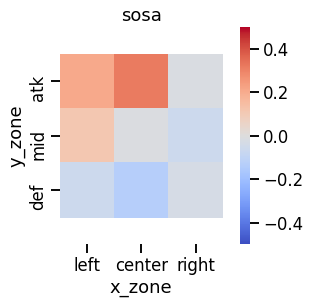

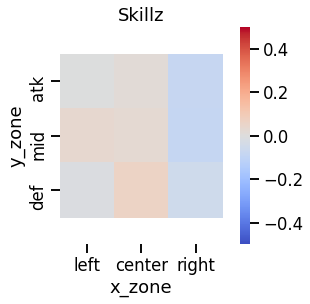

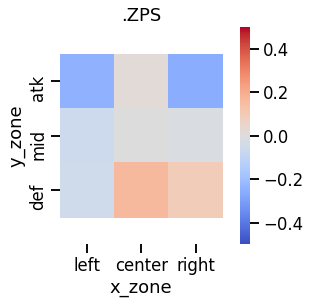

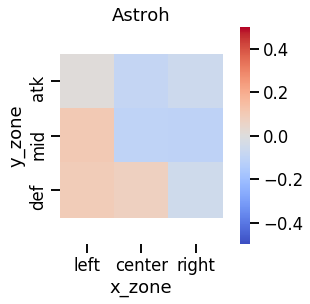

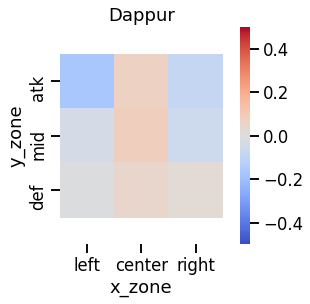

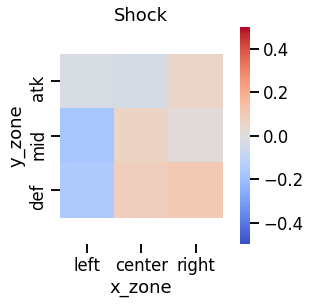

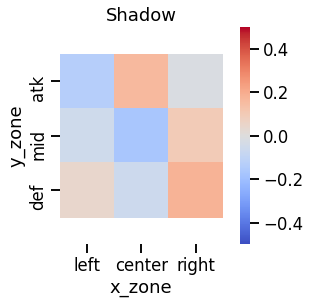

In [ ]:
for player_name in df_goal_rt.loc[:, 'name'].unique():
  make_positional_heatmap(player_name,zone_type='xy')

## XZ heatmaps ("Goalie heatmaps")  

* Get the last frame before a goal and use that as ball position   

* Player positioning   

* Contact position point  

In [ ]:
_df = df_goals.copy()
_df['frames'] = _df['goal_frame_number'].sub(1)
df_goalie_heatmaps = df_ball.merge(_df)
df_goalie_heatmaps.loc[df_goalie_heatmaps['is_orange']==False,'pos_x'] = df_goalie_heatmaps.loc[df_goalie_heatmaps['is_orange']==False,'pos_x'].mul(-1)

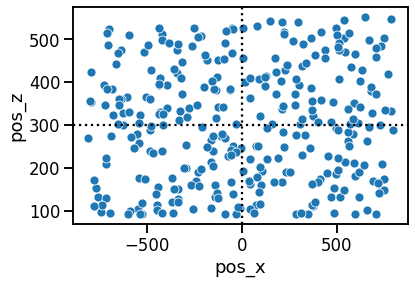

In [ ]:
sns.scatterplot('pos_x','pos_z',data=df_goalie_heatmaps)
plt.axvline(0,ls=':',c='k')
plt.axhline(300,ls=':',c='k')

In [ ]:
df_hits.sample(10)

,match_id,game_id,goal,frame_number,player_id,collision_distance,pos_x,pos_y,pos_z,distance,distance_to_goal,next_hit_frame_number,goal_number,is_kickoff,player_name
1097,D05674C411E9EC7CF5513DA05FFACFCB,CCF069784899273CC8A95DB9FAA7D06A,False,5943,76561198349297431,134.466644,2534.229980,3186.550049,412.910004,2841.203125,3947.460449,5986,0,False,Comm™
9159,31F694F811E9F78A355186985FFA0FCB,B418925A4E39E51E67C35EBE025FC1C1,False,8097,76561198247356798,128.893814,-3090.320068,4465.000000,138.899994,1271.289551,9852.464844,8123,4,False,Sea-Bass
548,38B4FC5611E9EC7474513CA511F19F61,1B6DFEAC4686F2316E545DACC502C028,False,2643,76561198123428030,160.496109,580.070007,-5132.979980,470.970001,1429.524658,10378.482422,2695,0,False,Demo
10933,5CDA1F8C11E9FCFD87EF8196777CAF14,AF3C4EBF427C72B13C792CA515CE1C0E,False,7699,76561198349297431,220.845901,3339.370117,-2433.949951,547.729980,3805.525391,5026.038574,7747,2,False,Comm™
4512,A3A8B74811E9F1F907D1098558717AA1,A84D106B4B169A77FDCE81A56D5D50EB,False,5726,76561197994317590,173.666565,-3520.439941,4318.109863,111.620003,79.191963,9815.473633,5728,1,False,"Turinturo,"
12716,50204ECA11EA027E15511D83DFFAEFCB,5D17058F4FAC24DB1E3F05AE543860ED,False,7176,76561198106926788,222.532745,1924.750000,679.869995,1271.489990,111.002983,6467.419922,7177,2,False,Aeon
4337,ADBCEC0811E9F1FAB55109855FFA8FCB,CD342D1A4DD777A99260A7A926336AA4,False,11114,76561197992682099,138.358170,1233.410034,-4499.529785,539.979980,3418.557617,9871.925781,11192,-1,False,CorruptedG
13650,F9BC88D011EA02845551A8ACDFFA2FCB,BCAD51D34939F6D3E30EC4A5A03500B1,False,2962,76561198168350330,173.376740,-1474.599976,2678.419922,441.700012,793.608215,7839.800293,2973,1,False,joefreshness
3965,36495A2211E9F1F487EF879B777CAF14,1AFD84B845835B9EAB574B917C5B8E71,False,392,76561198085890569,172.057724,3974.879883,3480.429932,1472.609985,934.027832,9901.377930,408,0,False,Shock
15733,4803300C11EA0294BF91EFAEE6B1C041,8E083CB342C79E44E2C523B852203AA6,False,2693,76561198237544110,221.303818,3968.590088,1465.319946,1276.540039,6318.681152,8203.321289,2759,1,False,Buddy


## Velo interaction  


In [ ]:
flat_df['id'] = flat_df['id'].astype(int)

In [ ]:
cols = ['game_id','frames','id','ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'distance_to_goal', 'goal']
cols2 = ['boost','boost_active', 'boost_collect', 'frames',
         'game_id','id','pos_x', 'pos_y', 'pos_z','vel_x', 'vel_y',
       'vel_z', 'x_zone', 'y_zone', 'z_zone', 'magnitude','name','team']

In [ ]:
_data = df_hits.rename(columns={'frame_number':'frames',
                                      'player_name':'name',
                                      'pos_x':'ball_pos_x',
                                      'pos_y':'ball_pos_y',
                                      'pos_z':'ball_pos_z'})
df_velo = flat_df.merge(_data,on=['game_id','frames','name'],suffixes=('','_ball'))
df_velo.loc[df_velo['is_orange']==True,['vel_x', 'vel_y','ball_pos_x','ball_pos_y','pos_x','pos_y']] = df_velo.loc[df_velo['is_orange']==True,['vel_x', 'vel_y','ball_pos_x','ball_pos_y','pos_x','pos_y']].mul(-1)
df_velo['magnitude'] = calc_magnitude(df_velo)

In [ ]:
_opp = (df_velo
 .loc[:,['game_id','frames','is_orange',
         'ball_pos_x', 'ball_pos_y','ball_pos_z']]
 .merge(flat_df
        .loc[:,['game_id','frames','name',
                'is_orange','pos_x', 'pos_y',
                'pos_z', 'vel_x', 'vel_y','vel_z']],
        on=['game_id','frames'],
        suffixes=('','_opp')))

_opp.loc[_opp['is_orange']==True,['vel_x', 'vel_y','pos_x','pos_y']] = _opp.loc[_opp['is_orange']==True,['vel_x', 'vel_y','pos_x','pos_y']].mul(-1)
_opp = _opp.loc[_opp['is_orange']!=_opp['is_orange_opp']]
for axis in ['x','y','z']:
  _opp[f'{axis}_diff'] = _opp[f"ball_pos_{axis}"].sub(_opp[f"pos_{axis}"])

_opp['3d_distance_to_ball'] = np.sqrt(_opp['x_diff']**2+_opp['y_diff']**2+_opp['z_diff']**2)
_opp = _opp.sort_values(['game_id','frames','3d_distance_to_ball']).drop_duplicates(subset=['game_id','frames'])
_opp['magnitude'] = calc_magnitude(_opp)
_rename = {v:f'opp_{v}' for v in ['pos_x','pos_y','pos_z','magnitude']}
df_opp = _opp.loc[:,['game_id','frames','pos_x','pos_y','pos_z','magnitude']].rename(columns=_rename)

In [ ]:
df_velo = df_velo.merge(df_opp)

In [ ]:
model_feats = ['ball_pos_x','ball_pos_y','ball_pos_z',
               'pos_x','pos_y','pos_z',
               'magnitude','opp_pos_x', 'opp_pos_y',
               'opp_pos_z', 'opp_magnitude']
target='goal'
_holdout_data = df_velo.loc[df_velo['goal']==1,model_feats+[target]].sample(frac=0.1)

_test_data = df_velo.loc[(~df_velo.index.isin(_holdout_data.index.values))&
                         (df_velo['goal']==1),
                         model_feats+[target]].sample(_holdout_data.shape[0])

test_data = df_velo.loc[df_velo['goal']==0,model_feats+[target]].sample(_test_data.shape[0])
test_data = test_data.append(_test_data)

_train_data = df_velo.loc[(~df_velo.index.isin(test_data.index.values))&
                          (df_velo['goal']==1),
                          model_feats+[target]]
train_data = df_velo.loc[df_velo['goal']==0,
                         model_feats+[target]].sample(_train_data.shape[0])
train_data = train_data.append(_train_data)

holdout_data = df_velo.loc[(~df_velo.index.isin(train_data.index.values))&
                           (~df_velo.index.isin(test_data.index.values)),
                           model_feats+[target]]
holdout_data = holdout_data.append(_holdout_data)


In [ ]:
model = LogisticRegression()
model.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
_pred = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),
             index=test_data.index,columns=['no_goal','goal'])
test_data['goal_pred'] = _pred['goal']

In [ ]:
test_data['goal_pred'].round(0).value_counts()

0.0    31
1.0    31
Name: goal_pred, dtype: int64

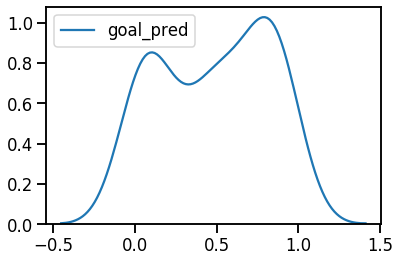

In [ ]:
sns.kdeplot(test_data['goal_pred'])

In [ ]:
accuracy_score(test_data['goal'],test_data['goal_pred'].round(0))

0.8709677419354839

In [ ]:
_pred = pd.DataFrame(model.predict_proba(holdout_data.loc[:,model_feats]),
             index=holdout_data.index,columns=['no_goal','goal'])
holdout_data['goal_pred'] = _pred['goal']

In [ ]:
holdout_data['goal_pred'].round(0).value_counts()

0.0    11217
1.0     4210
Name: goal_pred, dtype: int64

In [ ]:
holdout_data['goal'].round(0).value_counts()

0.0    15396
1.0       31
Name: goal, dtype: int64

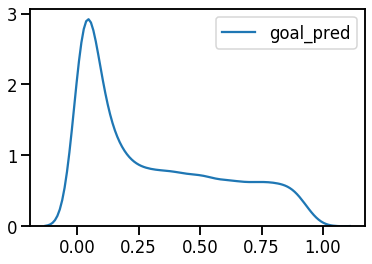

In [ ]:
sns.kdeplot(holdout_data['goal_pred'])

In [ ]:
accuracy_score(holdout_data['goal'],holdout_data['goal_pred'].round(0))

0.7289816555389901

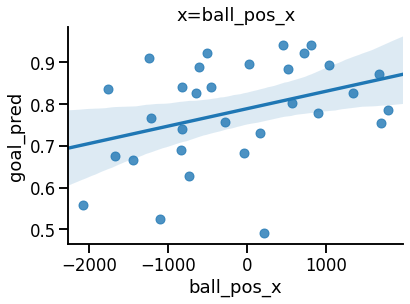

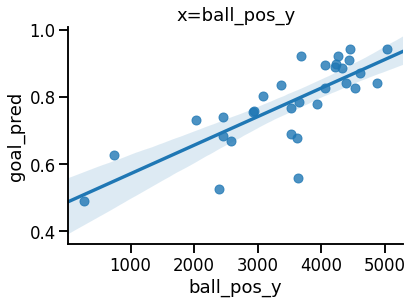

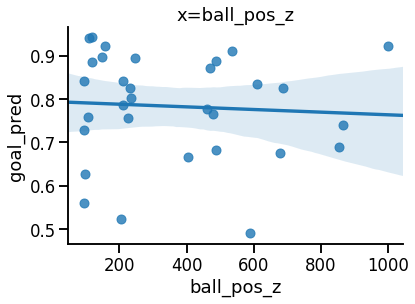

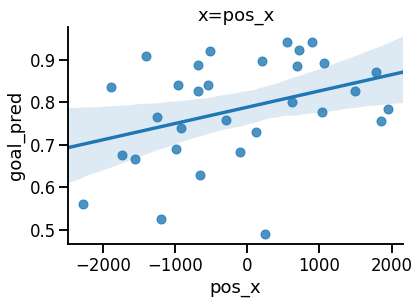

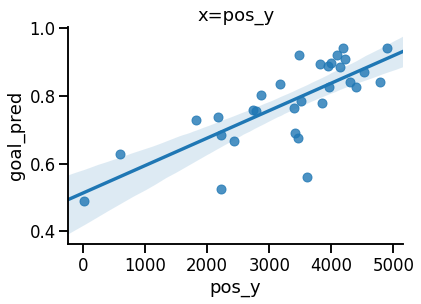

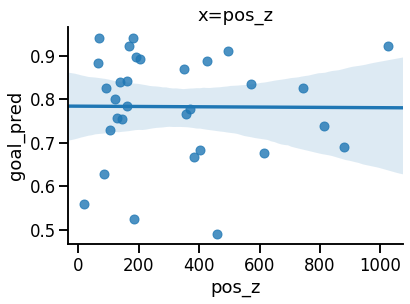

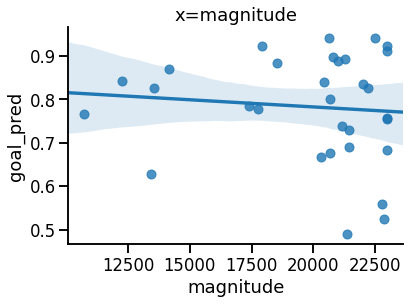

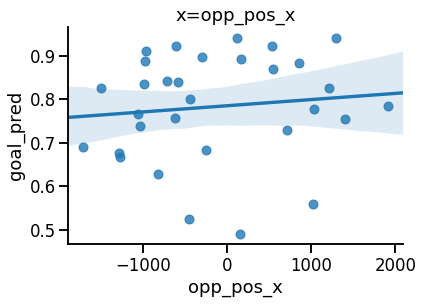

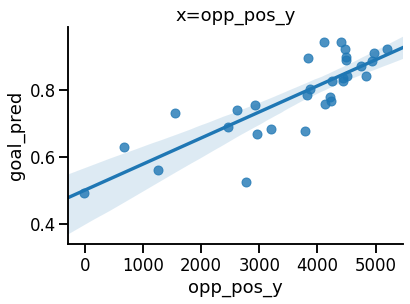

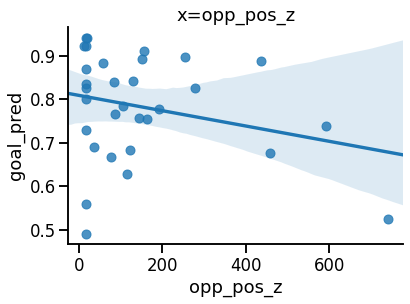

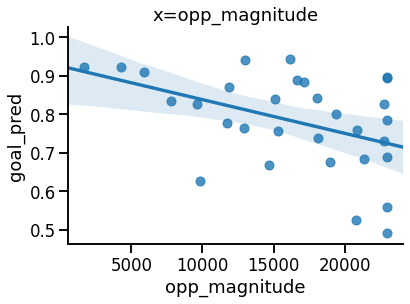

In [ ]:
df_plt = holdout_data.loc[holdout_data['goal']==True].sort_values('goal_pred',ascending=False)
for col in ['ball_pos_x', 'ball_pos_y', 'ball_pos_z',
            'pos_x', 'pos_y','pos_z', 'magnitude',
            'opp_pos_x', 'opp_pos_y','opp_pos_z', 'opp_magnitude']:

  sns.regplot(col,'goal_pred',data=df_plt)
  plt.title(f"x={col}")
  sns.despine()
  plt.show()

In [ ]:
pd.DataFrame(model.coef_,columns=model_feats)

,ball_pos_x,ball_pos_y,ball_pos_z,pos_x,pos_y,pos_z,magnitude,opp_pos_x,opp_pos_y,opp_pos_z,opp_magnitude
0,-0.000005,0.008099,-0.002374,0.000134,-0.007436,0.002037,-0.000028,-0.000028,-0.000144,-0.000658,-0.000046


count    16012.000000
mean     16589.349220
std       5125.264983
min         54.115617
25%      13072.769328
50%      17366.192202
75%      20913.724126
max      22999.996893
Name: magnitude, dtype: float64

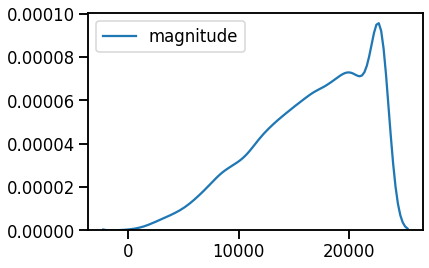

In [ ]:
sns.kdeplot(df_velo['magnitude'])
df_velo['magnitude'].describe()

In [ ]:
model_feats = ['ball_pos_x','ball_pos_y','ball_pos_z',
               'pos_x','pos_y','pos_z','magnitude',
            'opp_pos_x', 'opp_pos_y','opp_pos_z', 'opp_magnitude']
target='goal'

_holdout_data = df_velo.loc[df_velo['goal']==1,model_feats+[target]].sample(frac=0.1)

test_data = df_velo.loc[(~df_velo.index.isin(_holdout_data.index.values)),
                        model_feats+[target]].sample(frac=0.2)

train_data = df_velo.loc[(~df_velo.index.isin(_holdout_data.index.values))&
                         (~df_velo.index.isin(test_data.index.values)),
                         model_feats+[target]]

holdout_data = df_velo.loc[(~df_velo.index.isin(train_data.index.values))&
                           (~df_velo.index.isin(test_data.index.values)),
                           model_feats+[target]]
holdout_data = holdout_data.append(_holdout_data)


In [ ]:
lgb_train = lgb.Dataset(train_data.loc[:,model_feats],train_data.loc[:,target])
lgb_test = lgb.Dataset(test_data.loc[:,model_feats],test_data.loc[:,target])
lgb_holdout = lgb.Dataset(holdout_data.loc[:,model_feats],holdout_data.loc[:,target])

In [ ]:
['linear','exponential','gradient_boosting',
 'neural_net','cool_dude_function']

['linear',
 'exponential',
 'gradient_boosting',
 'neural_net',
 'cool_dude_function']

In [ ]:
df_tuning = pd.DataFrame()

for val in [1+(0.25*x) for x in range(9)]:
  p = dict(
      objective='binary',
      boosting='gbdt',
      num_leaves=15,
      n_estimators=1000,
      lambda_l1=val,
      lambda_l2=2.5,
      learning_rate=0.01,
      scale_pos_weight=1.5
  )
  model = lgb.train(p,train_set=lgb_train,valid_sets=lgb_test,
                    early_stopping_rounds=300,verbose_eval=False)
  x = model.best_score
  df_tuning = df_tuning.append(pd.DataFrame([[val,x['valid_0']['binary_logloss']]],columns=['tuning_param_val','logloss']),ignore_index=True)

df_tuning

,tuning_param_val,logloss
0,1.00,0.074089
1,1.25,0.073890
2,1.50,0.074156
3,1.75,0.074335
4,2.00,0.074743
5,2.25,0.074424
6,2.50,0.074441
7,2.75,0.074897
8,3.00,0.074750


key | range | value | loss | acc  
--- | --- | --- | --- | ---  
num_leaves | range(2,2000,10) | 15 | 0.01 | 0.532  
n_estimators | range(1,4000,10) | 1000 | 0.008 | 0.57  
... | ... | ... | ... | ...  
learning_rate | [0.1,.01,.001] | .01 | 0.0004 | 0.732  
num_leaves | range(2,2000,10) | 15 | 0.01 | 0.532  
n_estimators | range(1,4000,10) | 1000 | 0.008 | 0.57  

In [ ]:
p = dict(
    objective='binary',
    boosting='gbdt',
    num_leaves=15,
    n_estimators=1000,
    lambda_l1=2.5,
    lambda_l2=2.5,
    learning_rate=0.01,
    scale_pos_weight=1.5
)
model = lgb.train(p,train_set=lgb_train,valid_sets=lgb_test,
                  early_stopping_rounds=300,verbose_eval=False)

In [ ]:
test_data[f'{target}_prob'] = pd.Series(model.predict(test_data.loc[:,model_feats]),index=test_data.index)
test_data.loc[:,'xG'] = 0
test_data.loc[test_data[f'{target}_prob']>test_data[f'{target}_prob'].median(),'xG'] = 1

holdout_data[f'{target}_prob'] = pd.Series(model.predict(holdout_data.loc[:,model_feats]),index=holdout_data.index)
holdout_data.loc[:,'xG'] = 0
holdout_data.loc[holdout_data[f'{target}_prob']>holdout_data[f'{target}_prob'].median(),'xG'] = 1

,0,1
0,0.498436,0.481539
1,0.001564,0.018461


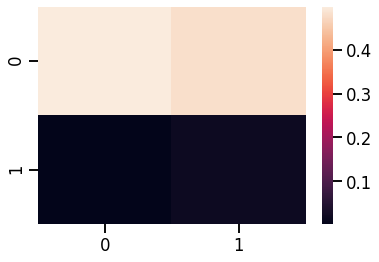

In [ ]:
df_confusion = pd.DataFrame(confusion_matrix(test_data['goal'],test_data['xG']))
df_confusion = df_confusion.div(df_confusion.sum().sum())
sns.heatmap(df_confusion)
df_confusion

In [ ]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.initjs()

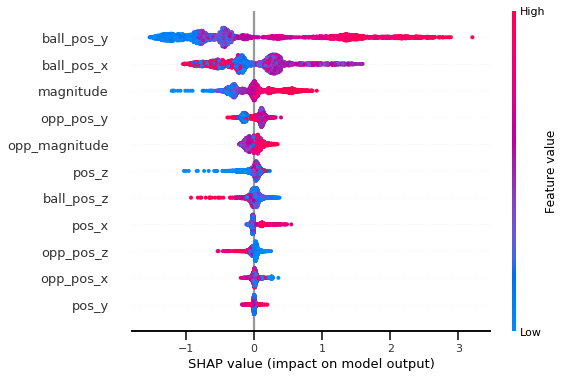

In [ ]:
shap.summary_plot(shap_values[1], shap_data)

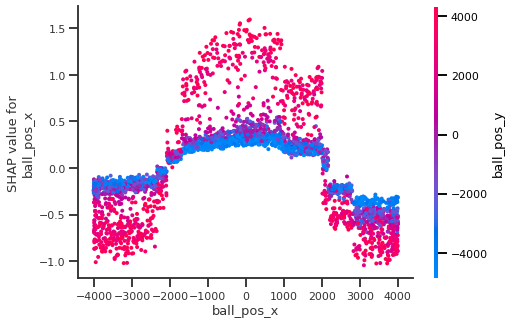

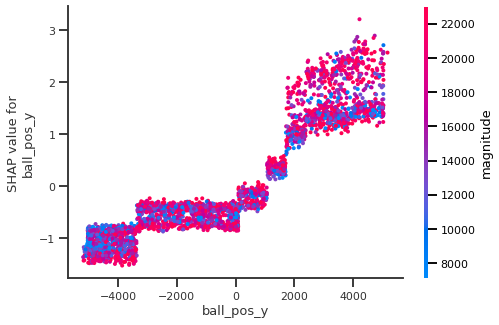

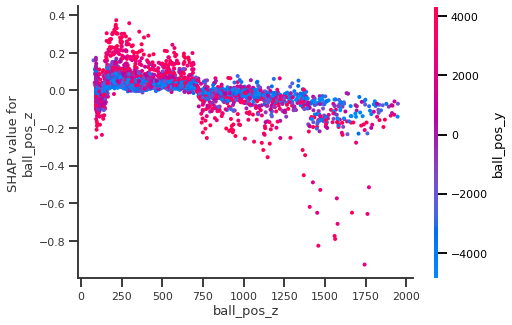

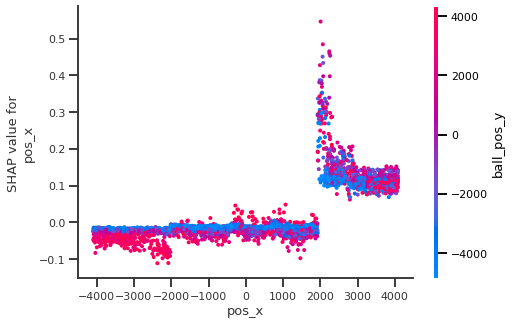

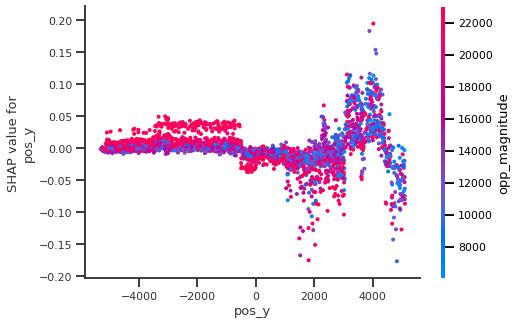

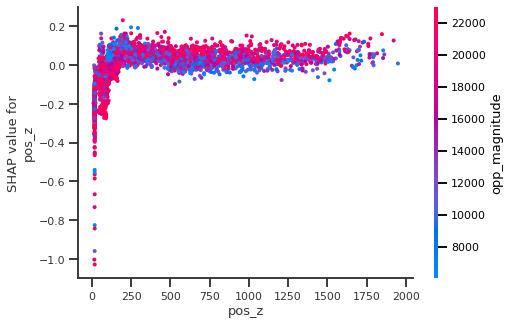

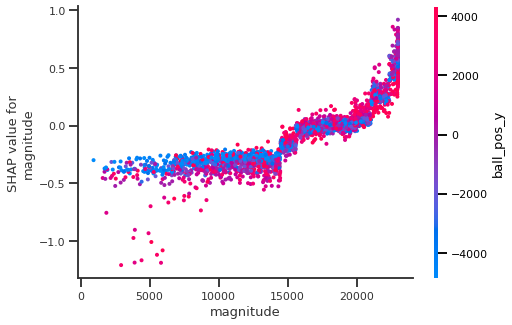

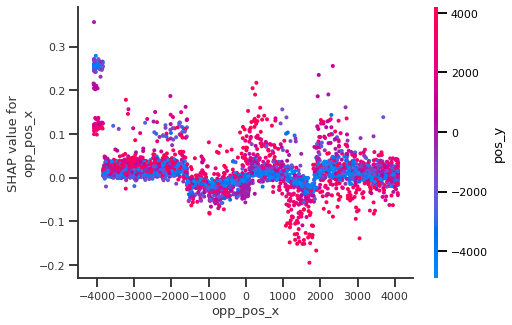

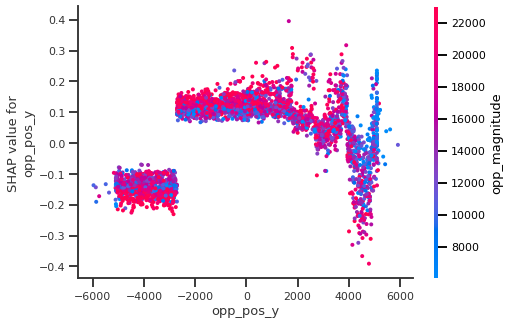

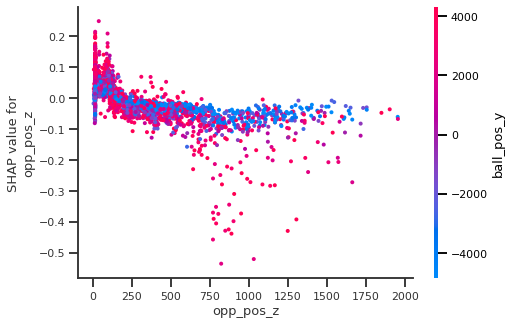

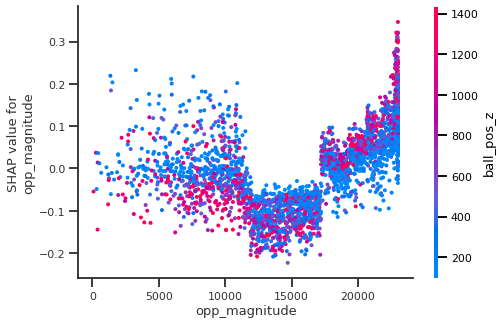

In [ ]:
for name in shap_data.columns:
    shap.dependence_plot(name, shap_values[1], shap_data)

In [ ]:
print(accuracy_score(test_data['goal'],test_data['xG'].round(0)))
print(accuracy_score(holdout_data['goal'],holdout_data['xG'].round(0)))

0.5168961201501877
0.4838709677419355


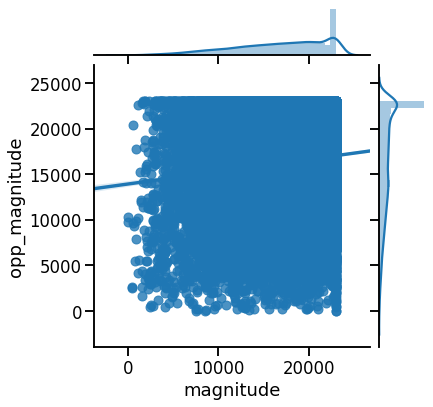

In [ ]:
sns.jointplot('magnitude','opp_magnitude',df_velo,kind='reg')
plt.show()

In [ ]:
test_data.loc[test_data['goal']==1].describe()

,ball_pos_x,ball_pos_y,ball_pos_z,pos_x,pos_y,pos_z,magnitude,opp_pos_x,opp_pos_y,opp_pos_z,opp_magnitude,goal_prob,xG
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,215.037078,3126.954596,359.922711,238.345625,2950.278542,316.086250,19829.886547,157.087292,3607.996042,178.912917,14582.830722,0.222666,0.958333
std,1431.315175,1435.528783,286.570364,1521.565020,1437.583929,293.291271,3295.890031,1518.064195,1450.367163,229.980703,6408.237410,0.201184,0.201941
min,-2747.669922,-308.570007,92.209999,-2986.080000,-516.490000,53.040000,11881.809900,-2978.470000,-288.880000,16.940000,2121.288849,0.001908,0.000000
25%,-654.922485,2220.890015,161.945000,-659.690000,1973.695000,123.652500,17349.098786,-773.232500,3257.297500,17.020000,10104.633346,0.028435,1.000000
50%,86.970001,3517.089966,274.194992,150.645000,3421.210000,213.950000,21335.547668,142.950000,4055.215000,96.905000,14515.266515,0.192384,1.000000
75%,969.912491,4156.577515,470.445000,1074.997500,3947.280000,414.070000,22999.883862,995.675000,4507.267500,203.072500,20765.498279,0.327726,1.000000
max,3373.709961,4730.629883,1520.660034,3499.650000,4600.360000,1568.100000,22999.989998,3605.950000,5507.710000,933.160000,22999.960941,0.739541,1.000000


In [ ]:
test_data.loc[test_data['goal']==0].describe()

,ball_pos_x,ball_pos_y,ball_pos_z,pos_x,pos_y,pos_z,magnitude,opp_pos_x,opp_pos_y,opp_pos_z,opp_magnitude,goal_prob,xG
count,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000
mean,-12.817437,-772.847528,532.978742,-14.798428,-887.497017,450.478933,16491.691228,-7.962592,-167.380943,279.131455,16180.245618,0.019153,0.493011
std,2443.844803,3029.720741,444.815401,2452.058590,3023.982437,436.419475,5132.559224,2479.452912,3042.326533,371.999261,5618.447089,0.058144,0.500031
min,-4007.100098,-5211.689941,87.300003,-4085.500000,-5320.410000,8.920000,59.684588,-4087.850000,-5949.660000,8.460000,250.521955,0.000767,0.000000
25%,-2200.950012,-3678.577576,149.157505,-2180.092500,-3798.730000,97.122500,13042.063159,-2217.412500,-2903.005000,17.017500,12012.782053,0.001821,0.000000
50%,2.610000,-889.839996,362.639999,14.760000,-1023.445000,271.740000,17282.027104,-1.615000,-73.965000,100.450000,16907.651644,0.003318,0.000000
75%,2186.002502,1829.022522,839.562500,2172.935000,1712.242500,728.297500,20800.659630,2124.387500,2456.810000,403.580000,21297.071772,0.008785,1.000000
max,4002.429932,5029.819824,1954.540039,4081.150000,5130.950000,1990.150000,22999.992395,4084.550000,5942.140000,2019.460000,22999.995265,0.762142,1.000000


In [ ]:
test_data.sort_values('goal_prob',ascending=False)

,ball_pos_x,ball_pos_y,ball_pos_z,pos_x,pos_y,pos_z,magnitude,opp_pos_x,opp_pos_y,opp_pos_z,opp_magnitude,goal,goal_prob,xG
12268,-164.729996,4213.240234,194.649994,-192.63,4025.20,156.90,20265.079435,-3223.68,3281.76,84.80,22984.739413,True,0.738500,1
10883,491.760010,4191.680176,204.500000,491.92,4009.82,219.73,22999.970785,230.64,4165.59,17.01,9967.175350,False,0.608016,1
11440,103.480003,4730.629883,372.609985,173.24,4577.56,308.09,16064.580077,281.27,4891.98,385.76,2884.624721,True,0.595258,1
3987,70.459999,4404.939941,157.699997,-117.19,4132.11,110.43,22999.960880,2014.48,4356.73,70.45,17939.543231,True,0.565898,1
2626,-805.340027,4488.529785,276.170013,-861.19,4337.59,161.59,22999.882958,-1370.04,5102.94,679.05,9849.287343,True,0.503306,1
5260,-512.000000,4727.750000,659.710022,-596.18,4556.67,543.72,22999.901953,-114.18,4943.24,442.33,8849.834252,False,0.481917,1
6101,718.799988,3678.479980,157.559998,716.73,3479.23,168.17,22999.945950,531.64,4469.19,11.26,4264.873617,True,0.471102,1
432,-388.160004,4620.779785,632.830017,-320.71,4541.65,454.66,22999.966218,-508.08,5185.50,416.20,21729.770918,False,0.465550,1
2755,-330.269989,3220.669922,406.320007,-141.32,3157.75,308.26,22966.258695,-1701.81,3768.40,17.01,7896.400923,False,0.455850,1
1854,850.840027,4692.049805,439.899994,840.54,4554.51,390.13,21418.184070,-381.81,3087.45,17.03,14661.309515,True,0.455131,1


# RL scouting reports  

* goals, assists, blocks   
* positional strengths/weaknesses
* match up predictions  

data i have:  
* flat_df [player positioning data]  
* df_ball [ball position]  
* df_goals [ball position, frame of goal, player data]  
* df_hits [anytime a player touched the ball]  



In [ ]:
rl_report = flat_df.loc[flat_df['x_zone'].notnull()].copy()
flip_cols = [x for x in rl_report.columns.values if x[-2:] in ['_x','_y']]
rl_report.loc[rl_report['is_orange']==True,flip_cols+['x_zone','y_zone']] = rl_report.loc[rl_report['is_orange']==True,flip_cols+['x_zone','y_zone']].mul(-1)
rl_report['team'] = rl_report['team'].replace('UPPER 90 ESPORTS','UPPER 90')
for col in ['x_zone','y_zone','z_zone']:
  rl_report[col] = rl_report[col].astype(int)

game_count = rl_report.loc[:,['game_id','team','name','id']].drop_duplicates()
game_count['game'] = 1
game_count = game_count.groupby(['team','name','id'],as_index=False).sum()

df_goals['goal'] = 1
goals_per_game = df_goals.loc[:,['game_id','name','goal']].groupby(['game_id','name'],as_index=False).sum()
goals_per_game = game_count.merge(goals_per_game.groupby(['name'],as_index=False).sum())
_goals_per_game = goals_per_game.groupby(['team','id'],as_index=False).sum()
_goals_per_game['goals_per_game'] = _goals_per_game['goal'].div(_goals_per_game['game'])
goals_per_game = goals_per_game.merge(_goals_per_game.loc[:,['team','id','goals_per_game']])

hits_per_game = df_hits.loc[(df_hits['is_kickoff']==False)].rename(columns={'player_name':'name'})
hits_per_game['hit'] = 1
hits_per_game = hits_per_game.loc[:,['game_id','name','hit']].groupby(['game_id','name'],as_index=False).sum()
hits_per_game = game_count.merge(hits_per_game.groupby(['name'],as_index=False).sum())
_hits_per_game = hits_per_game.groupby(['team','id'],as_index=False).sum()
_hits_per_game['hits_per_game'] = _hits_per_game['hit'].div(_hits_per_game['game'])
hits_per_game = hits_per_game.merge(_hits_per_game.loc[:,['team','id','hits_per_game']])

touches = goals_per_game.merge(hits_per_game)
touches['goals_per_hit'] = touches['goal'].div(touches['hit'])

avg_pos = rl_report.loc[:,['x_zone','y_zone','z_zone']]
for col in ['x_zone','y_zone']:
  avg_pos[col] = avg_pos[col].replace(range(-1,2),range(3))

avg_pos = avg_pos.mean()

positional_data = rl_report.loc[:,['team','name','id','x_zone','y_zone','z_zone']]
for col in ['x_zone','y_zone']:
  positional_data[col] = positional_data[col].replace(range(-1,2),range(3))

positional_data = positional_data.groupby(['team','name','id'],as_index=False).mean()
positional_data.loc[:,['x_zone','y_zone','z_zone']] = (positional_data.loc[:,['x_zone','y_zone','z_zone']].sub(avg_pos)).div(avg_pos)
_positional_data = positional_data.loc[:,['id','x_zone','y_zone','z_zone']].groupby('id',as_index=False).mean()
positional_data = positional_data.loc[:,['team','name','id']].merge(_positional_data)

touches = touches.merge(positional_data)

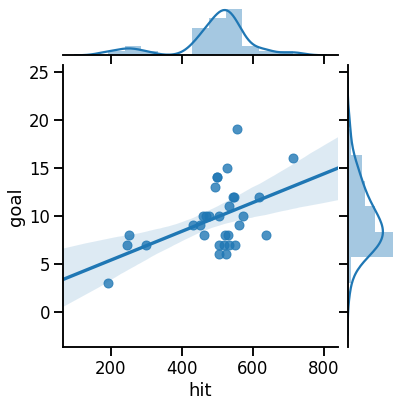

In [ ]:
sns.jointplot('hit','goal',data=touches,kind='reg')

-0.03834828509922744

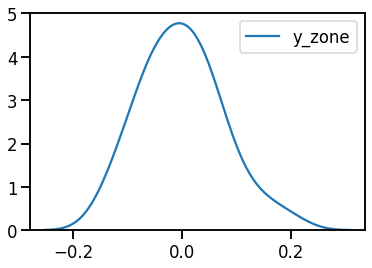

In [ ]:
sns.kdeplot(touches['y_zone'])
touches['y_zone'].mean()-(touches['y_zone'].std()/2)

In [ ]:
touches.loc[touches['y_zone']>0.035,'player_type'] = 'offensive'
touches.loc[touches['y_zone']<-0.04,'player_type'] = 'defensive'
touches.loc[:,'player_type'] = touches.loc[:,'player_type'].fillna('2way')

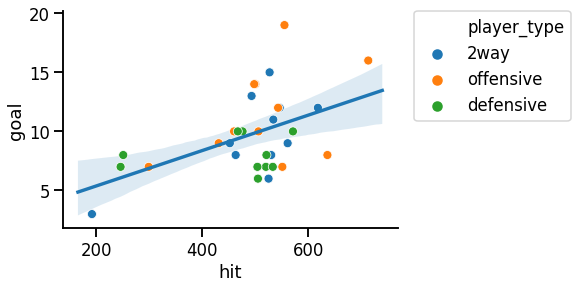

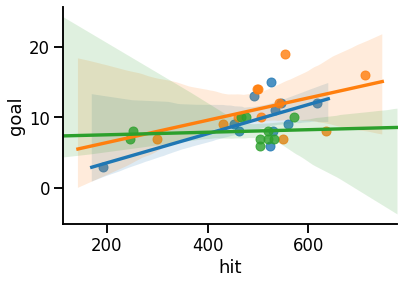

In [ ]:
sns.regplot('hit','goal',data=touches,marker='.')
sns.scatterplot('hit','goal',data=touches,hue='player_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

for pt in touches['player_type'].unique():
  sns.regplot('hit','goal',data=touches.loc[touches['player_type']==pt])
sns.despine()
plt.show()

In [ ]:
touches.loc[touches['team']=='FMG',['name','goals_per_game','hits_per_game','goals_per_hit','player_type']]

,name,goals_per_game,hits_per_game,goals_per_hit,player_type
12,Buddy,0.368421,27.368421,0.013462,defensive
13,Thundah,0.789474,27.736842,0.028463,2way
14,"Turinturo,",0.842105,37.526316,0.022440,offensive


In [ ]:
avg_pos = rl_report.loc[:,['team','x_zone','y_zone','z_zone']]
for col in ['x_zone','y_zone']:
  avg_pos[col] = avg_pos[col].replace(range(-1,2),range(3))

avg_pos = avg_pos.groupby('team',as_index=False).mean()
positional_data = rl_report.loc[:,['team','name','id','x_zone','y_zone','z_zone']]
for col in ['x_zone','y_zone']:
  positional_data[col] = positional_data[col].replace(range(-1,2),range(3))

positional_data = positional_data.groupby(['team','name','id'],as_index=False).mean()
positional_data = positional_data.merge(avg_pos,on=['team'],suffixes=('','_avg'))
for col in ['x_zone','y_zone','z_zone']:
  positional_data[f"{col}_pct"] = (positional_data.loc[:,col].sub(positional_data.loc[:,f'{col}_avg'])).div(positional_data.loc[:,f'{col}_avg'])

_positional_data = positional_data.loc[:,['id','x_zone_pct','y_zone_pct','z_zone_pct']].groupby('id',as_index=False).mean()
team_positions = positional_data.loc[:,['team','name','id']].merge(_positional_data)

count    32.000000
mean      0.000234
std       0.041071
min      -0.117716
25%      -0.027192
50%       0.001761
75%       0.028956
max       0.082929
Name: y_zone_pct, dtype: float64

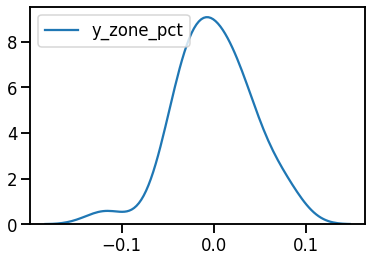

In [ ]:
sns.kdeplot(team_positions['y_zone_pct'])
team_positions['y_zone_pct'].describe()

In [ ]:
pos_thresholds = [team_positions['y_zone_pct'].mean()-(team_positions['y_zone_pct'].std()/2),
                  team_positions['y_zone_pct'].mean()+(team_positions['y_zone_pct'].std()/2)]

In [ ]:
team_positions.loc[team_positions['y_zone_pct']>pos_thresholds[1],'team_role'] = 'offensive'
team_positions.loc[team_positions['y_zone_pct']<pos_thresholds[0],'team_role'] = 'defensive'
team_positions.loc[:,'team_role'] = team_positions.loc[:,'team_role'].fillna('2way')

In [ ]:
team_positions['team_role'].value_counts()

2way         13
offensive    10
defensive     9
Name: team_role, dtype: int64

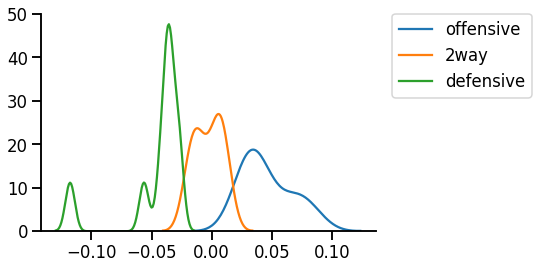

In [ ]:
for pt in ['offensive','2way','defensive']:
  sns.kdeplot(team_positions.loc[team_positions['team_role']==pt,'y_zone_pct'],label=pt)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

In [ ]:
touches = touches.merge(team_positions.loc[:,['id','x_zone_pct','y_zone_pct','z_zone_pct','team_role']])

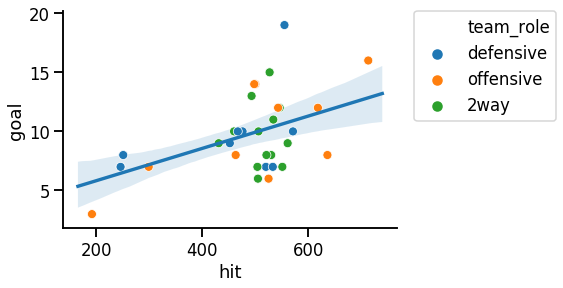

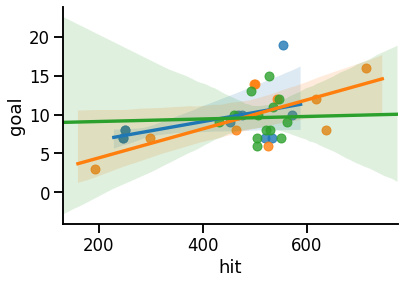

In [ ]:
sns.regplot('hit','goal',data=touches,marker='.')
sns.scatterplot('hit','goal',data=touches,hue='team_role')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

for pt in touches['team_role'].unique():
  sns.regplot('hit','goal',data=touches.loc[touches['team_role']==pt])
sns.despine()
plt.show()

In [ ]:
touches.loc[touches['team']=='FMG']

,team,name,id,game,goal,goals_per_game,hit,hits_per_game,goals_per_hit,x_zone,y_zone,z_zone,player_type,x_zone_pct,y_zone_pct,z_zone_pct,team_role
12,FMG,Buddy,76561198237544112,19,7,0.368421,520,27.368421,0.013462,-0.000472,-0.065813,-0.026954,defensive,0.009339,-0.056305,-0.007698,defensive
13,FMG,Thundah,76561198319558352,19,15,0.789474,527,27.736842,0.028463,-0.034378,-0.003631,-0.170417,2way,-0.024900,0.006511,-0.154000,2way
14,FMG,"Turinturo,",76561197994317584,19,16,0.842105,713,37.526316,0.022440,0.006037,0.036798,0.138481,offensive,0.015912,0.047351,0.161011,offensive


# Write up?  
## Descriptive stats
* where's the ball
* where's the players
* where do goals come from
* how fast do goals get scored?  

## Conditional descriptive stats  
* how fast does a player score goals?
* how many tit-for-tat goals does a player score?
* how fast is a player's tft goals?  

## Describe phenomena  
* does velocity matter?  
* how much do aerials matter?  
* are players naturally offensive/defensive?  

## Consolodate information  
* what information is important to help game-plan?  
* what information is more trivial?  
* what information can be used as competitive advantage?  

## Improve analytics  
* what would make a good statistic better?  
* what would make a trivial statistic useful?  


# MATCH UP MODEL???
* agg the team stats?  
* represent each player as multiple columns?
* could aggregate two-player combos then agg the results?  


count    43186.000000
mean        54.463229
std         83.856758
min          1.000000
25%         12.000000
50%         22.000000
75%         34.000000
max        310.000000
Name: boost_collect, dtype: float64

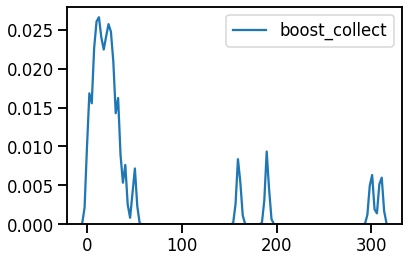

In [ ]:
sns.kdeplot(rl_report['boost_collect'])
rl_report['boost_collect'].describe()


In [ ]:
rl_report.loc[:,['boost','boost_active', 'boost_collect']].sample(20)

,boost,boost_active,boost_collect
5052408,192.000000,False,NaN
2804233,212.321050,True,NaN
4798007,34.000000,False,NaN
3914482,255.000000,False,NaN
1627318,148.865643,True,NaN
141449,85.000000,False,NaN
2916511,85.544826,True,NaN
4697505,85.000000,False,NaN
4795730,85.000000,False,NaN
4846245,255.000000,False,NaN


In [ ]:
rl_report.columns.values

array(['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'ball_cam', 'boost',
       'boost_active', 'boost_collect', 'dodge_active',
       'double_jump_active', 'frames', 'game_id', 'game_number',
       'handbrake', 'id', 'is_orange', 'jump_active', 'match_date',
       'match_id', 'name', 'ping', 'pos_x', 'pos_y', 'pos_z', 'rot_x',
       'rot_y', 'rot_z', 'steer', 'team', 'throttle', 'vel_x', 'vel_y',
       'vel_z', 'x_zone', 'y_zone', 'z_zone'], dtype=object)

In [ ]:
teams_players = rl_report.loc[:,['name','team','id']].drop_duplicates()
rl_goals = df_goals.drop('id',axis=1)
rl_goals = rl_goals.merge(teams_players,on=['name'])
rl_goals['goal'] = 1
_rl_goals = rl_goals.loc[:,['game_id','team','goal']].groupby(['game_id','team'],as_index=False).sum()
_rl_goals
_rl_goals = _rl_goals.merge(rl_report.loc[:,['game_id','team']].drop_duplicates(),
                how='right')
_rl_goals['goal'] = _rl_goals['goal'].fillna(0).astype(int)
rl_goals = _rl_goals.sort_values(['game_id','goal'],ascending=[1,0]).reset_index(drop=True)
df_win = rl_goals.drop_duplicates('game_id')
df_win['win']=1
rl_goals = rl_goals.merge(df_win.loc[:,['game_id','team','win']],how='left')
rl_goals['win'] = rl_goals['win'].fillna(0).astype(int)
rl_goals = rl_goals.rename(columns={'goal':'total_team_goals'})
rl_report = rl_report.merge(rl_goals)

In [ ]:
touches.columns.values

array(['team', 'name', 'id', 'game', 'goal', 'goals_per_game', 'hit',
       'hits_per_game', 'goals_per_hit', 'x_zone', 'y_zone', 'z_zone',
       'player_type', 'x_zone_pct', 'y_zone_pct', 'z_zone_pct',
       'team_role'], dtype=object)

In [ ]:
matchup = rl_report.loc[:,['game_id','team','name','id','win']].drop_duplicates()
matchup = matchup.merge(touches.loc[:,['team','name','id','goals_per_game',
                             'hits_per_game', 'goals_per_hit',
                             'x_zone', 'y_zone', 'z_zone',
                             'x_zone_pct', 'y_zone_pct', 'z_zone_pct']])

In [ ]:
stat_cols = ['goals_per_game', 'hits_per_game', 'goals_per_hit',
             'x_zone', 'y_zone', 'z_zone', 'x_zone_pct',
             'y_zone_pct', 'z_zone_pct']

model_data = pd.DataFrame()
for gid in tqdm_notebook(matchup['game_id'].unique(),leave=True):
  _matchup = matchup.loc[matchup['game_id']==gid]
  for team_idx,tid in enumerate(_matchup['team'].unique()):
    if team_idx == 0:
      _team1 = _matchup.loc[_matchup['team']==tid]
      _team = _team1
    else:
      _team2 = _matchup.loc[_matchup['team']==tid]
      _team = _team2

    for idx,pid in enumerate(_team['id'].unique()):
      rename_stat_cols = {k:f"{k}_{idx}" for k in stat_cols}
      _player = _team.loc[_team['id']==pid,['game_id', 'team', 'win']+stat_cols].rename(columns=rename_stat_cols)
      if idx == 0:
        team = _player
      else:
        team = team.merge(_player)

      _team_expanded = pd.DataFrame()
      for p in itertools.permutations(range(3)):
        a = {k:f"{k[:-1]}{p[0]}" for k in team.columns.values if k[-2:] == '_0'}
        b = {k:f"{k[:-1]}{p[1]}" for k in team.columns.values if k[-2:] == '_1'}
        c = {k:f"{k[:-1]}{p[2]}" for k in team.columns.values if k[-2:] == '_2'}
        stupid_rename_thing = {**a,**b,**c}
        _team_expanded = _team_expanded.append(team.rename(columns=stupid_rename_thing),ignore_index=True)

      if team_idx == 0:
        team1 = _team_expanded.copy()
      else:
        team2 = _team_expanded.copy()

  team_game = team1.merge(team2,on=['game_id'],suffixes=('_0','_1'))
  team_game = team_game.append(team2.merge(team1,on=['game_id'],suffixes=('_0','_1')),ignore_index=True)

  model_data = model_data.append(team_game,ignore_index=True)
model_data['win'] = model_data['win_1']

In [ ]:
model_feats = ['goals_per_game_0_0', 'goals_per_game_1_0',
       'goals_per_game_2_0', 'goals_per_hit_0_0', 'goals_per_hit_1_0',
       'goals_per_hit_2_0', 'hits_per_game_0_0', 'hits_per_game_1_0',
       'hits_per_game_2_0', 'x_zone_0_0', 'x_zone_1_0',
       'x_zone_2_0', 'x_zone_pct_0_0', 'x_zone_pct_1_0', 'x_zone_pct_2_0',
       'y_zone_0_0', 'y_zone_1_0', 'y_zone_2_0', 'y_zone_pct_0_0',
       'y_zone_pct_1_0', 'y_zone_pct_2_0', 'z_zone_0_0', 'z_zone_1_0',
       'z_zone_2_0', 'z_zone_pct_0_0', 'z_zone_pct_1_0', 'z_zone_pct_2_0',
       'goals_per_game_0_1', 'goals_per_game_1_1', 'goals_per_game_2_1',
       'goals_per_hit_0_1', 'goals_per_hit_1_1', 'goals_per_hit_2_1',
       'hits_per_game_0_1', 'hits_per_game_1_1', 'hits_per_game_2_1',
       'x_zone_0_1', 'x_zone_1_1', 'x_zone_2_1',
       'x_zone_pct_0_1', 'x_zone_pct_1_1', 'x_zone_pct_2_1', 'y_zone_0_1',
       'y_zone_1_1', 'y_zone_2_1', 'y_zone_pct_0_1', 'y_zone_pct_1_1',
       'y_zone_pct_2_1', 'z_zone_0_1', 'z_zone_1_1', 'z_zone_2_1',
       'z_zone_pct_0_1', 'z_zone_pct_1_1', 'z_zone_pct_2_1']

target = 'win'

In [ ]:
test_games = model_data['game_id'].drop_duplicates().sample(20)
test_data = model_data.loc[model_data['game_id'].isin(test_games.values)]
train_data = model_data.loc[~model_data.index.isin(test_data.index.values)]
print(f"train size: {train_data.shape[0]}\ntest size: {test_data.shape[0]}")

In [ ]:
model = LogisticRegression()
model.fit(train_data.loc[:,model_feats],train_data.loc[:,target])

In [ ]:
test_data[f'{target}_prob'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index, columns=[0,f'{target}_prob'])[f'{target}_prob']
print(f"log loss: {log_loss(test_data[target], test_data[f'{target}_prob'])}")
print(f"accuracy: {accuracy_score(test_data[target], test_data[f'{target}_prob'].round(0))}")

In [ ]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats], feature_dependence="independent")
shap_values = explainer.shap_values(shap_data)
shap.initjs()


In [ ]:
shap.summary_plot(shap_values, shap_data)

In [ ]:
all_matches = pd.DataFrame()
for team1, team2 in itertools.product(model_data['team_0'].unique(),model_data['team_0'].unique()):
  matches = matchup.loc[matchup['game_id'].isin(model_data.loc[(model_data['team_0']==team1)&(model_data['team_1']==team2),'game_id'].unique()),['game_id','team','win']].drop_duplicates()
  matches = matches.loc[matches['team']==team1,['game_id','team']].merge(matches.loc[matches['team']==team2],on=['game_id'],suffixes=('1','2'))
  matches['win_prob'] = matchup_win_prob(model_data,touches,team1,team2)
  all_matches = all_matches.append(matches,ignore_index=True)

In [ ]:
target='win'
print(f"log loss: {log_loss(all_matches[target], all_matches[f'{target}_prob'])}")
print(f"accuracy: {accuracy_score(all_matches[target], all_matches[f'{target}_prob'].round(0))}")

In [ ]:
all_matches.loc[all_matches['team2']=='BULL SEND']

## where to improve to gain win prob?
tune through the stats and find the shortest tuning distance?

In [ ]:
increments

In [ ]:
team_str = '0'
col = 'goals_per_game'
[x for x in win_prob_data.columns.values if x[:-4] in col]
# cols_to_tune = [y for y in [x for x in win_prob_data.columns.values if x[:-4] in col] if y[-1] == team_str]
# cols_to_tune

In [ ]:
win_prob_data

In [ ]:
def data_tuning(win_prob_data, increments, col, improve=True):
  df = win_prob_data.copy()
  if improve:
    team_str = '1'
  else:
    team_str = '0'
  cols_to_tune = [y for y in [x for x in win_prob_data.columns.values if x[:-4] in col] if y[-1] == team_str]
  rand_col = random.choice(cols_to_tune)
  df.loc[:,rand_col] = win_prob_data.loc[:,rand_col].add(increments[col])
  return df

In [ ]:
increments.keys()

In [ ]:
opp_id = 'BULL SEND'
bullsend_id = 'BULL SEND'
increments = get_increments(model_data)
win_prob_data = get_win_prob_data(opp_id, bullsend_id, touches)
print(get_win_probability(opp_id,bullsend_id,model_data,win_prob_data)[0][1])

col = 'goals_per_game'
# for col in increments.keys():
for _ in range(1000):
  win_prob_data = win_prob_data.append(data_tuning(win_prob_data, increments, col, improve=True),ignore_index=True)

In [ ]:
win_prob_data

In [ ]:
matchup_win_prob(model_data,touches,'BULL SEND',team2='BULL SEND')

In [ ]:
_opp

## places to improve  
* use game level data aggregates instead of season level aggregates  
* predict series win probability instead of game win probability  
* use predicted tendencies based on match up  
include more events (assists, demos, boosts)  
* use more time series based data (first half, second half, OT)  
* given a loss, update series win probability  
* different modeling techniques  